# Tutorial 1: Bank Closure Replication - Kang, Lowery & Wardlaw (RFS 2015)

This notebook replicates the structural estimation of bank closure decisions from:

**"The Costs of Closing Failed Banks: A Structural Estimation of Regulatory Incentives"**
*Kang, Lowery & Wardlaw, Review of Financial Studies (2015)*

## Overview

The paper estimates:
1. **Regulatory preferences**: How regulators trade off resolution costs vs. political pressure
2. **Political influence**: Effect of congressional committee membership on closure decisions

Instead of solving the full dynamic programming problem, we:
1. Estimate **conditional choice probabilities** (CCPs) directly from data
2. Use CCPs to construct **expected continuation values**
3. Recover structural parameters via **GMM**

---

# 1. Economic Framework

## 1.1 The Research Question

**Economic Question**: What are the structural parameters governing bank regulators' decisions to close a bank?

**Object of Interest**: 
- Discount factor ($\beta$) - how much do regulators value future costs?
- Scale parameter ($\sigma$) - how much heterogeneity exists in unobserved closure costs?
- Net monetary cost function parameters ($\theta_{NMC}$) - how do bank characteristics affect operating costs?

**Identification**: The CCP approach (Hotz-Miller 1993) identifies the value function difference from observed closure probabilities. The key identifying assumption is that unobserved shocks follow the Type-I Extreme Value distribution.

**Sample**: 22,269 bank-quarter observations during the S&L Crisis era (1985Q4-1992Q4).

## 1.2 The Dynamic Discrete Choice Model

### State Variables

At each period $t$, a bank is characterized by state vector $s_t$:
- **Equity ratio** ($equity\_a$): Capital buffer against losses
- **Non-performing loans ratio** ($npf\_a$): Measure of asset quality
- **Log assets** ($\log(assets)$): Bank size
- **Real estate owned ratio** ($realest\_a$): Foreclosed properties
- **Return on assets** ($roa$): Profitability
- **Political indices** ($House$, $Senate$): Regulatory environment

### Value Functions

The regulator's value function for keeping the bank **open**:

$$V_{\text{open}}(s_t) = MC(s_t) + \beta \cdot \mathbb{E}_t[V(s_{t+1})]$$

where:
- $MC(s_t)$ = Net monetary cost of operating the bank (negative if bank is profitable)
- $\beta$ = Discount factor
- $\mathbb{E}_t[V(s_{t+1})]$ = Expected continuation value

The value of **closing** the bank: $V_{\text{close}}(s_t) = 0$ (normalized)

### Choice Probabilities

With Type-I Extreme Value (logit) errors, the probability of closing is:

$$P(\text{close} | s_t) = \frac{1}{1 + \exp\left(\frac{V_{\text{open}}(s_t) - V_{\text{close}}(s_t)}{\sigma}\right)}$$

## 1.3 The CCP Approach (Hotz-Miller 1993)

### The Inversion Formula

From the logit formula:

$$\sigma \cdot \log\left(\frac{1 - P_t}{P_t}\right) = V_{\text{open}}(s_t) - V_{\text{close}}(s_t)$$

### The Euler Equation / Moment Condition

Substituting the value function:

$$g(\theta) = \sigma \cdot \log\left(\frac{1-P_t}{P_t}\right) + \beta\sigma \cdot \mathbb{E}[\ln P_{t+1}] - \beta \cdot \mathbb{E}[MC_{t+1}] + MC_t$$

### Structural Parameters (10 total)

- $\beta$: Discount factor (quarterly)
- $\sigma$: Scale of idiosyncratic closure cost
- $\theta_{NMC}$: Coefficients of the net monetary cost function (8 parameters)

---

# Setup: Import Libraries

In [1]:
# Core scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.special import expit  # Logistic function
import scipy.io as sio
from scipy.stats import norm  # For Tobit conditional expectation
from tabulate import tabulate

# Visualization
import matplotlib.pyplot as plt

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.6f}'.format)
np.set_printoptions(precision=6, suppress=True)

# Plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
# =============================================================================
# MODEL SPECIFICATION - Configure all variables here
# =============================================================================
"""
This configuration block defines the entire model specification.
All estimation code below reads from these dictionaries.
To modify the model, change ONLY this cell.
"""

from dataclasses import dataclass, field
from typing import List, Dict, Optional

# -----------------------------------------------------------------------------
# 1. SAMPLE SELECTION
# -----------------------------------------------------------------------------
SAMPLE_CONFIG = {
    'start_yearq': (1985, 4),  # Start quarter (year, quarter)
    'end_yearq': (1992, 4),    # End quarter
    'yearq_base': 1960,        # Base year for yearq coding
}

# Convert to numeric yearq
def yearq_to_numeric(year, quarter, base=1960):
    return (year - base) * 4 + (quarter - 1)

SAMPLE_CONFIG['start_numeric'] = yearq_to_numeric(*SAMPLE_CONFIG['start_yearq'])
SAMPLE_CONFIG['end_numeric'] = yearq_to_numeric(*SAMPLE_CONFIG['end_yearq'])

# -----------------------------------------------------------------------------
# 2. STATE VARIABLES (Bank-level, time-varying)
# -----------------------------------------------------------------------------
# IMPORTANT: lag_names must match ACTUAL column names in the data
# The data uses inconsistent naming conventions for lags

STATE_VARIABLES = {
    'log_assets': {
        'data_name': 'log_assets',
        'display_name': 'Log(Assets)',
        'n_lags': 4,
        'lag_names': ['log_assets', 'log_assets_lag1', 'log_assets_lag2', 'log_assets_lag3'],
        'lag4_name': 'log_assets_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': True,
        'bounds': None,
    },
    'equity_a': {
        'data_name': 'equity_a',
        'display_name': 'Equity/Assets',
        'n_lags': 4,
        'lag_names': ['equity_a', 'equity_a_lag1', 'equity_a_lag2', 'equity_a_lag3'],
        'lag4_name': 'equity_a_lag4',  # For AR(4) regressors
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': True,
        'bounds': None,
    },
    'nonperf_loans_a': {
        'data_name': 'nonperf_loans_a',
        'display_name': 'NPL/Assets',
        'n_lags': 4,
        # Note: current is nonperf_loans_a, but lags use nonperf_a_lag*
        'lag_names': ['nonperf_loans_a', 'nonperf_a_lag1', 'nonperf_a_lag2', 'nonperf_a_lag3'],
        'lag4_name': 'nonperf_a_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': True,
        'bounds': (0, None),
    },
    'real_estate_owned_a': {
        'data_name': 'real_estate_owned_a',
        'display_name': 'REO/Assets',
        'n_lags': 4,
        # Note: current is real_estate_owned_a, but lags use realEst_own_a_lag*
        'lag_names': ['real_estate_owned_a', 'realEst_own_a_lag1', 'realEst_own_a_lag2', 'realEst_own_a_lag3'],
        'lag4_name': 'realEst_own_a_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': True,
        'bounds': (0, None),
    },
    'roa_annual': {
        'data_name': 'roa_annual',
        'display_name': 'ROA (Annual)',
        'n_lags': 4,
        'lag_names': ['roa_annual', 'roa_annual_lag1', 'roa_annual_lag2', 'roa_annual_lag3'],
        'lag4_name': 'roa_annual_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': True,
        'bounds': None,
    },
    'asset_growth_1y': {
        'data_name': 'asset_growth_1y',
        'display_name': 'Asset Growth (1Y)',
        'n_lags': 4,
        # Note: current is asset_growth_1y, but lags use assGrowth_1y_lag*
        'lag_names': ['asset_growth_1y', 'assGrowth_1y_lag1', 'assGrowth_1y_lag2', 'assGrowth_1y_lag3'],
        'lag4_name': 'assGrowth_1y_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': True,
        'in_cost': False,
        'bounds': None,
    },
}

# -----------------------------------------------------------------------------
# 3. MACRO/CONTROL VARIABLES
# -----------------------------------------------------------------------------
CONTROL_VARIABLES = {
    'unemp_state': {
        'data_name': 'unemp_state',
        'display_name': 'State Unemployment',
        'n_lags': 4,
        'lag_names': ['unemp_state', 'unemp_state_lag1', 'unemp_state_lag2', 'unemp_state_lag3'],
        'lag4_name': 'unemp_state_lag4',
        'in_transition': True,
        'in_ccp': True,
        'use_bspline': False,
        'in_cost': True,
    },
}

# -----------------------------------------------------------------------------
# 4. POLITICAL VARIABLES (for structural model)
# -----------------------------------------------------------------------------
POLITICAL_VARIABLES = {
    'House_index': {
        'data_name': 'House_index',
        'display_name': 'House Committee',
        'in_ccp': True,
        'use_bspline': False,
    },
    'Senate_index': {
        'data_name': 'Senate_index',
        'display_name': 'Senate Committee',
        'in_ccp': True,
        'use_bspline': False,
    },
}

# -----------------------------------------------------------------------------
# 5. OUTCOME VARIABLE
# -----------------------------------------------------------------------------
OUTCOME_CONFIG = {
    'data_name': 'failed',
    'display_name': 'Bank Closed',
}

# -----------------------------------------------------------------------------
# 6. COST MODEL SPECIFICATION (Tobit)
# -----------------------------------------------------------------------------
COST_MODEL_CONFIG = {
    'dependent_var': 'resolution_cost_a',
    'display_name': 'Net Monetary Cost / Assets',
}

# -----------------------------------------------------------------------------
# 7. CCP MODEL SPECIFICATION (Logit + B-splines)
# -----------------------------------------------------------------------------
CCP_CONFIG = {
    'n_knots': 4,
    'degree': 1,
    'n_lags_in_ccp': 4,
}

# -----------------------------------------------------------------------------
# 8. SIMULATION CONFIGURATION
# -----------------------------------------------------------------------------
SIMULATION_CONFIG = {
    'n_draws': 5000,
    'residual_trim': (0.5, 99.5),
    'seed': 42,
}

# -----------------------------------------------------------------------------
# 9. GMM CONFIGURATION
# -----------------------------------------------------------------------------
GMM_CONFIG = {
    'discount_factor_bounds': (0.8, 0.9999),
    'initial_theta': [0.95, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
}

# -----------------------------------------------------------------------------


# -----------------------------------------------------------------------------
# 10. COST MODEL (Tobit) SPECIFICATION
# -----------------------------------------------------------------------------
# Variables that enter the monetary cost function (Table 3)
COST_VARS_SPEC = [
    {'name': 'log_assets', 'display': 'Log(assets)'},
    {'name': 'equity_a', 'display': 'Equity/assets'},
    {'name': 'nonperf_loans_a', 'display': 'NP loans/assets'},
    {'name': 'real_estate_owned_a', 'display': 'RE owned/assets'},
    {'name': 'roa_annual', 'display': 'Net income/assets'},
    {'name': 'unemp_state', 'display': 'State unemployment'},
]

# -----------------------------------------------------------------------------
# 11. NON-MONETARY COST (NMC) FUNCTION SPECIFICATION - Table 7
# -----------------------------------------------------------------------------
# Defines how the NMC function is constructed for GMM
# Each entry: {'name': var_name, 'transform': None/'squared', 'source': 'state'/'political'/'computed'}
NMC_SPEC = [
    {'name': 'const', 'transform': None, 'source': 'const'},
    {'name': 'log_assets', 'transform': None, 'source': 'state'},
    {'name': 'log_assets', 'transform': 'squared', 'source': 'state'},
    {'name': 'nonperf_loans_a', 'transform': None, 'source': 'state'},
    {'name': 'roa_annual', 'transform': None, 'source': 'state'},
    {'name': 'real_estate_owned_a', 'transform': None, 'source': 'state'},
    {'name': 'House_index', 'transform': None, 'source': 'political'},
    {'name': 'Senate_index', 'transform': None, 'source': 'political'},
]

# Parameter names for NMC (matches NMC_SPEC order, excludes beta and sigma)
NMC_PARAM_NAMES = ['Intercept', 'log(Assets)', '(log Assets)^2', 
                   'NP Loans/Assets', 'Net Income/Assets', 'RE Owned/Assets',
                   'House', 'Senate']

# -----------------------------------------------------------------------------
# 12. GMM INSTRUMENTS SPECIFICATION
# -----------------------------------------------------------------------------
# Instruments for GMM estimation (Table 7 footnote)
GMM_INSTRUMENTS = [
    {'name': 'const', 'lag': 0},
    {'name': 'log_assets', 'lag': 0},
    {'name': 'log_assets', 'lag': 1},
    {'name': 'equity_a', 'lag': 0},
    {'name': 'nonperf_loans_a', 'lag': 0},
    {'name': 'real_estate_owned_a', 'lag': 0},
    {'name': 'roa_annual', 'lag': 0},
    {'name': 'asset_growth_1y', 'lag': 0},
    {'name': 'unemp_state', 'lag': 0},
    {'name': 'House_index', 'lag': 0},
    {'name': 'Senate_index', 'lag': 0},
]

# -----------------------------------------------------------------------------
# 13. STRUCTURAL PARAMETERS
# -----------------------------------------------------------------------------
STRUCTURAL_PARAMS = {
    'beta': {'name': 'β (discount)', 'bounds': (0.8, 0.9999), 'initial': 0.954},
    'sigma': {'name': 'σ (scale)', 'bounds': (1, 2000), 'initial': 577},
    # NMC initial values (order matches NMC_SPEC)
    'nmc_initials': [-468922, 85603, -3914, -33825, -54826, -146756, -420, 11]
}

# GMM estimation settings
GMM_SETTINGS = {
    'method': 'L-BFGS-B',  # scipy.optimize method
    'maxiter': 100,
    'tol': 1e-8,
}

# Total number of parameters: 2 (beta, sigma) + len(NMC_SPEC)
N_PARAMS = 2 + len(NMC_SPEC)

def get_structural_param_names():
    """Get ordered list of parameter names for display."""
    names = ['β (discount)', 'σ (scale)']  # First two params
    for spec in NMC_SPEC:
        var_name = spec['name']
        transform = spec.get('transform', None)
        if var_name == 'const':
            names.append('Intercept')
        elif transform == 'squared':
            names.append(f'{var_name}²')
        else:
            names.append(var_name)
    return names

def get_nmc_var_names():
    """Get list of variables in NMC function."""
    return [spec['name'] for spec in NMC_SPEC if spec['source'] != 'const']

def get_cost_var_names():
    """Get list of variables in cost (Tobit) model."""
    return [spec['name'] for spec in COST_VARS_SPEC]

def get_instrument_names():
    """Get list of instruments."""
    return [(spec['name'], spec['lag']) for spec in GMM_INSTRUMENTS]

# HELPER FUNCTIONS TO ACCESS CONFIG
# -----------------------------------------------------------------------------
def get_transition_vars():
    """Variables with AR(4) transition models."""
    vars_list = []
    for name, cfg in STATE_VARIABLES.items():
        if cfg['in_transition']:
            vars_list.append(name)
    for name, cfg in CONTROL_VARIABLES.items():
        if cfg['in_transition']:
            vars_list.append(name)
    return vars_list

def get_ccp_bspline_vars():
    """Variables that get B-spline transformation in CCP."""
    vars_list = []
    for name, cfg in STATE_VARIABLES.items():
        if cfg['in_ccp'] and cfg['use_bspline']:
            vars_list.append(name)
    return vars_list

def get_ccp_linear_vars():
    """Variables that enter CCP linearly (no B-spline)."""
    vars_list = []
    for name, cfg in CONTROL_VARIABLES.items():
        if cfg['in_ccp'] and not cfg['use_bspline']:
            vars_list.append(name)
    for name, cfg in POLITICAL_VARIABLES.items():
        if cfg['in_ccp'] and not cfg['use_bspline']:
            vars_list.append(name)
    return vars_list

def get_cost_vars():
    """Variables in the cost (Tobit) model."""
    vars_list = []
    for name, cfg in STATE_VARIABLES.items():
        if cfg['in_cost']:
            vars_list.append(name)
    for name, cfg in CONTROL_VARIABLES.items():
        if cfg.get('in_cost', False):
            vars_list.append(name)
    return vars_list

def get_all_lag_names(var_name):
    """Get all lag column names for a variable (current + lags 1-3)."""
    if var_name in STATE_VARIABLES:
        return STATE_VARIABLES[var_name]['lag_names']
    elif var_name in CONTROL_VARIABLES:
        return CONTROL_VARIABLES[var_name]['lag_names']
    return [var_name]

def get_ar4_lag_names(var_name):
    """Get lag column names for AR(4) regressors (lags 1-4)."""
    if var_name in STATE_VARIABLES:
        cfg = STATE_VARIABLES[var_name]
        return cfg['lag_names'][1:] + [cfg['lag4_name']]  # lag1, lag2, lag3, lag4
    elif var_name in CONTROL_VARIABLES:
        cfg = CONTROL_VARIABLES[var_name]
        return cfg['lag_names'][1:] + [cfg['lag4_name']]
    return []

def get_var_config(var_name):
    """Get configuration for a variable."""
    if var_name in STATE_VARIABLES:
        return STATE_VARIABLES[var_name]
    elif var_name in CONTROL_VARIABLES:
        return CONTROL_VARIABLES[var_name]
    elif var_name in POLITICAL_VARIABLES:
        return POLITICAL_VARIABLES[var_name]
    return None

# Print configuration summary
print("Model Specification Loaded")
print("=" * 50)
print(f"Sample period: {SAMPLE_CONFIG['start_yearq']} to {SAMPLE_CONFIG['end_yearq']}")
print(f"State variables: {list(STATE_VARIABLES.keys())}")
print(f"Control variables: {list(CONTROL_VARIABLES.keys())}")
print(f"Political variables: {list(POLITICAL_VARIABLES.keys())}")
print(f"CCP B-spline vars: {get_ccp_bspline_vars()}")
print(f"CCP linear vars: {get_ccp_linear_vars()}")
print(f"Cost model vars: {get_cost_vars()}")
print(f"Simulation draws: {SIMULATION_CONFIG['n_draws']}")


Model Specification Loaded
Sample period: (1985, 4) to (1992, 4)
State variables: ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'asset_growth_1y']
Control variables: ['unemp_state']
Political variables: ['House_index', 'Senate_index']
CCP B-spline vars: ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'asset_growth_1y']
CCP linear vars: ['unemp_state', 'House_index', 'Senate_index']
Cost model vars: ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'unemp_state']
Simulation draws: 5000


---

# 2. Data Overview

## 2.1 Data Sources

The data comes from the **Call Reports** (quarterly regulatory filings by U.S. banks) covering:
- **Period**: 1985Q4 to 1992Q4 (the S&L Crisis era)
- **Sample**: 22,269 bank-quarter observations
- **Bank closures**: 714 failures (3.21%)

## 2.2 Data Pipeline: From Raw Data to Structural Estimation

The estimation follows the **Hotz-Miller (1993) CCP approach**. Before structural GMM, we estimate several reduced-form objects:

### Overview of Estimation Objects

| Economic Object | Method | Input | Output |
|----------------|--------|-------|--------|
| **Raw Panel** | — | `ccpdata_pvar_KLW.mat` | 48,245 obs → 22,269 after sample selection |
| **Transition** $f(x'|x)$ | AR(4) OLS | Raw panel | `coeff_resid_KLW.xlsx` |
| **Cost** $E[mc|x]$ | Tobit MLE | Failed banks | `coeff_resid_KLW.xlsx` |
| **CCP** $p(x)$ | Logit + B-splines | `dataforlogit_KLW.txt` | `logit_predict_KLW.txt` |
| **Forward Sim** | Monte Carlo | All above | `ccpnext_param_sim5000_KLW.txt` |
| **GMM Data** | Merge | All above | `dataforparam_KLW.mat` |
| **Structural θ** | CU-GMM | GMM Data | `theta_KLW.mat` |

### Data Flow

```
RAW PANEL ──┬── TRANSITION (AR4) ──┐
            │                      │
            ├── COST (Tobit) ──────┼── FORWARD SIM ── GMM DATA ── STRUCTURAL GMM
            │                      │      (5000 draws)
            └── CCP (Logit) ───────┘
```

Detailed explanations of each estimation step are provided in **Section 3** alongside the code.

## 2.3 Loading the Raw Panel Data

The raw panel data is stored in `ccpdata_pvar_KLW.mat` (48,245 bank-quarter observations).

**What this file contains:**
- Bank identifiers: `rssd_id`, `state`, `yearq`
- Outcome: `failed` (1 = closed by FDIC)
- State variables: `equity_a`, `nonperf_loans_a`, `log_assets`, `real_estate_owned_a`, `roa_annual`, `unemp_state`
- Lags (1-4) for each state variable (for AR(4) transition estimation)
- Political variables: `House_index`, `Senate_index`

**Sample selection** (applied below):
1. Period: 1985Q4–1992Q4 (Model I / S&L Crisis)
2. ROA < 0 (loss-making banks only, per paper)
3. Complete lags for AR(4) estimation

**Result**: 22,269 observations, 4,661 unique banks, 714 failures

In [3]:
# =============================================================================
# Load Processed Data from ccpdata_pvar_KLW.mat
# =============================================================================

DATA_PATH = './data/'
ccp_data = sio.loadmat(DATA_PATH + 'ccpdata_pvar_KLW.mat')

# Convert to DataFrame
df = pd.DataFrame({k: v.squeeze() for k, v in ccp_data.items() if not k.startswith('__') and k != 'V'})

# Decode yearq: 99 = 1984Q4, 100 = 1985Q1, ..., 103 = 1985Q4, ..., 131 = 1992Q4
total_q = 7940 + (df['yearq'].astype(int) - 99)  # 7940 = 1984*4 + 4 (1984Q4 as base)
df['year'] = (total_q - 1) // 4
df['quarter'] = ((total_q - 1) % 4) + 1
df['yearq_std'] = df['year'] * 10 + df['quarter']  # Standard YYYYQ format

# Summary
print(f"Loaded {len(df.columns)} variables, {len(df):,} observations")
print(f"Period: {df['year'].min()}Q{df.loc[df['yearq'].idxmin(), 'quarter']} - "
      f"{df['year'].max()}Q{df.loc[df['yearq'].idxmax(), 'quarter']}")
print(f"Banks: {df['rssd_id'].nunique():,} | Failures: {int(df['failed'].sum())} ({100*df['failed'].mean():.2f}%)")

Loaded 64 variables, 48,245 observations
Period: 1984Q4 - 1992Q4
Banks: 6,838 | Failures: 842 (1.75%)


In [4]:
# =============================================================================
# Sample Selection (KLW 2015, Section 3)
# =============================================================================
# Criteria:
# - Period: 1985Q4-1992Q4 (Model I) or 2008Q1-2012Q4 (Model V)
# - Assets >= $10M, equity/assets < 30%, asset growth <= 150%, assets < $3B
#   (already applied in ccpdata_pvar_KLW.mat)
# - ROA < 0 (GMM sample)
# - Complete lags 1-3 for AR(4) transition estimation
print("="*75)
print("Sample Selection")
print("="*75)

# 1. Period filter (Model I: 1985Q4-1992Q4)
df_s = df[(df['yearq'] >= 103) & (df['yearq'] <= 131)].copy()
print(f"1. Period 1985Q4-1992Q4:    {len(df_s):,} obs")

# 2. ROA < 0
df_s = df_s[df_s['roa_annual'] < 0]
print(f"2. ROA < 0:                 {len(df_s):,} obs")

# 3. Finite current values
for var in ['equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'log_assets']:
    df_s = df_s[np.isfinite(df_s[var])]
print(f"3. Finite current values:   {len(df_s):,} obs")

# 4. Complete lags 1-3 (required for AR transition estimation)
for lag in [1, 2, 3]:
    for var in [f'equity_a_lag{lag}', f'nonperf_a_lag{lag}', f'roa_annual_lag{lag}', f'log_assets_lag{lag}']:
        df_s = df_s[np.isfinite(df_s[var])]
print(f"4. Complete lags 1-3:       {len(df_s):,} obs")

df_sample = df_s.copy()

print(f"\n--- Final GMM Sample ---")
print(f"Observations: {len(df_sample):,}")
print(f"Unique banks: {df_sample['rssd_id'].nunique():,}")
print(f"Failures:     {int(df_sample['failed'].sum())} ({100*df_sample['failed'].mean():.2f}%)")
print(f"\nPaper:        22,269 obs, 4,661 banks, 714 failures (3.21%)")

Sample Selection
1. Period 1985Q4-1992Q4:    41,879 obs
2. ROA < 0:                 41,795 obs
3. Finite current values:   41,790 obs
4. Complete lags 1-3:       22,269 obs

--- Final GMM Sample ---
Observations: 22,269
Unique banks: 4,661
Failures:     714 (3.21%)

Paper:        22,269 obs, 4,661 banks, 714 failures (3.21%)


In [5]:
# =============================================================================
# TABLE 1: Summary Statistics (1985-1992)
# Replicating Table 1 from KLW (RFS 2015), page 16
# =============================================================================

print("="*75)
print("TABLE 1: Summary Statistics (1985-1992)")
print("="*75)

# Compute county deposits ($M) from log
df_sample['county_deposits_M'] = np.exp(df_sample['log_county_deposits']) / 1000

# Panel A: Quarterly Call Report data / macroeconomic and political conditions
table1_vars = [
    ('assets', 'Assets ($M)', 1e-3),
    ('equity_a', 'Equity/assets', 1),
    ('nonperf_loans_a', 'Nonperforming loans/assets', 1),
    ('real_estate_owned_a', 'Real estate owned/assets', 1),
    ('first_core_dep_a', 'Core deposits/assets', 1),
    ('roa_annual', 'Net income/assets', 1),
    ('us_equity_a', 'US equity/assets', 1),
    ('county_deposits_M', 'County deposits ($M)', 1),
    ('unemp_state', 'State unemployment rate (%)', 1),
    ('House_index', 'House', 1),
    ('Senate_index', 'Senate', 1),
]

print("\nPanel A: Quarterly Call Report data / macroeconomic and political conditions")
print("-"*75)

rows = []
for var, label, scale in table1_vars:
    arr = df_sample[var] * scale
    arr = arr[np.isfinite(arr)]  # Handle inf values in county_deposits
    rows.append([label, f"{arr.mean():.3f}", f"{arr.std():.3f}", 
                 f"{arr.quantile(0.05):.3f}", f"{arr.median():.3f}", f"{arr.quantile(0.95):.3f}"])

print(tabulate(rows, headers=['', 'Mean', 'Std', '5%', 'Median', '95%'], tablefmt='simple'))

print(f"\nObservations: {len(df_sample):,}")
print(f"Unique banks: {df_sample['rssd_id'].nunique():,}")

# Panel B: FDIC failure and merger data
print("\n" + "-"*75)
print("Panel B: FDIC failure and merger data")
print("-"*75)

failed_mask = df_sample['failed'] == 1
n_failures = int(df_sample['failed'].sum())
resolution_cost = df_sample.loc[failed_mask, 'estimated_cost'] / 1000  # to millions
cost_assets = df_sample.loc[failed_mask, 'estimated_cost'] / df_sample.loc[failed_mask, 'assets']

panel_b = [
    ['Failures', f"{n_failures}", '', '', '', ''],
    ['Resolution costs ($M)', f"{resolution_cost.mean():.3f}", f"{resolution_cost.std():.3f}",
     f"{resolution_cost.quantile(0.05):.3f}", f"{resolution_cost.median():.3f}", f"{resolution_cost.quantile(0.95):.3f}"],
    ['Cost/assets', f"{cost_assets.mean():.3f}", f"{cost_assets.std():.3f}",
     f"{cost_assets.quantile(0.05):.3f}", f"{cost_assets.median():.3f}", f"{cost_assets.quantile(0.95):.3f}"],
    ['Mergers', 'N/A', '', '', '', ''],
]

print(tabulate(panel_b, headers=['', 'Mean', 'Std', '5%', 'Median', '95%'], tablefmt='simple'))
print(f"\nNote: Merger data not available in replication files.")

TABLE 1: Summary Statistics (1985-1992)

Panel A: Quarterly Call Report data / macroeconomic and political conditions
---------------------------------------------------------------------------
                                 Mean        Std      5%    Median        95%
---------------------------  --------  ---------  ------  --------  ---------
Assets ($M)                   124.981    238.136  16.25     52.236    509.744
Equity/assets                   0.054      0.039   0         0.057      0.106
Nonperforming loans/assets      0.041      0.036   0.003     0.031      0.108
Real estate owned/assets        0.026      0.03    0         0.017      0.083
Core deposits/assets            0.229      0.065   0.101     0.242      0.312
Net income/assets              -0.022      0.024  -0.065    -0.014     -0.001
US equity/assets                0.064      0.003   0.061     0.063      0.072
County deposits ($M)         6290.81   13584      63.221   738.493  33598.4
State unemployment rate (%) 

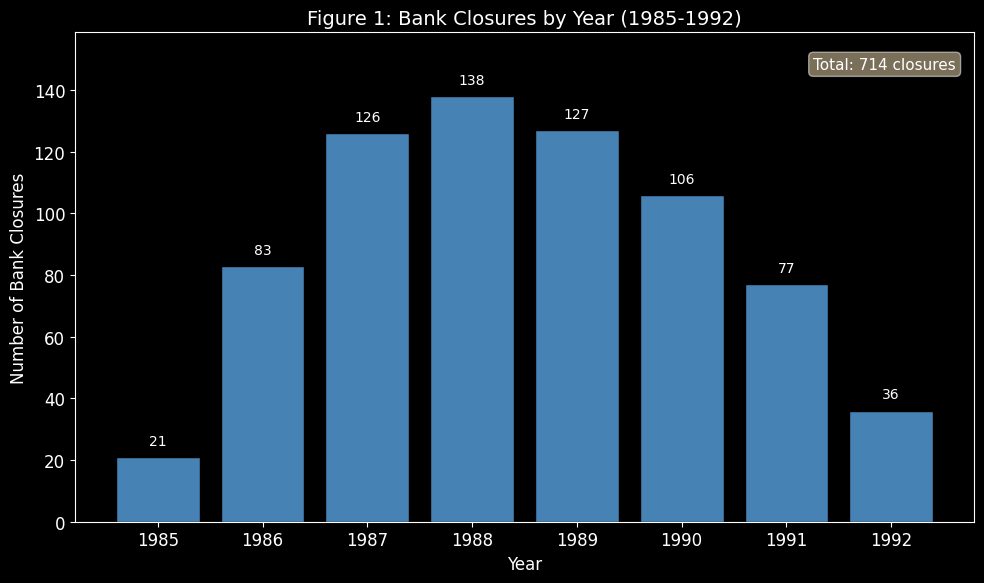

Sample: 22,269 bank-quarters, 4,661 unique banks


In [6]:
# =============================================================================
# FIGURE 1: Bank Closures by Year (1986-1992)
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Count failures by year
closures_by_year = df_sample.groupby('year')['failed'].sum()

# Bar chart
bars = ax.bar(closures_by_year.index, closures_by_year.values, color='steelblue', edgecolor='black')

# Add value labels on bars
for bar, val in zip(bars, closures_by_year.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
            f'{int(val)}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Bank Closures', fontsize=12)
ax.set_title('Figure 1: Bank Closures by Year (1985-1992)', fontsize=14)
ax.set_xticks(closures_by_year.index)
ax.set_ylim(0, max(closures_by_year.values) * 1.15)

# Add total annotation
ax.annotate(f'Total: {int(closures_by_year.sum())} closures', 
            xy=(0.98, 0.95), xycoords='axes fraction',
            ha='right', va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Sample: {len(df_sample):,} bank-quarters, {df_sample['rssd_id'].nunique():,} unique banks")

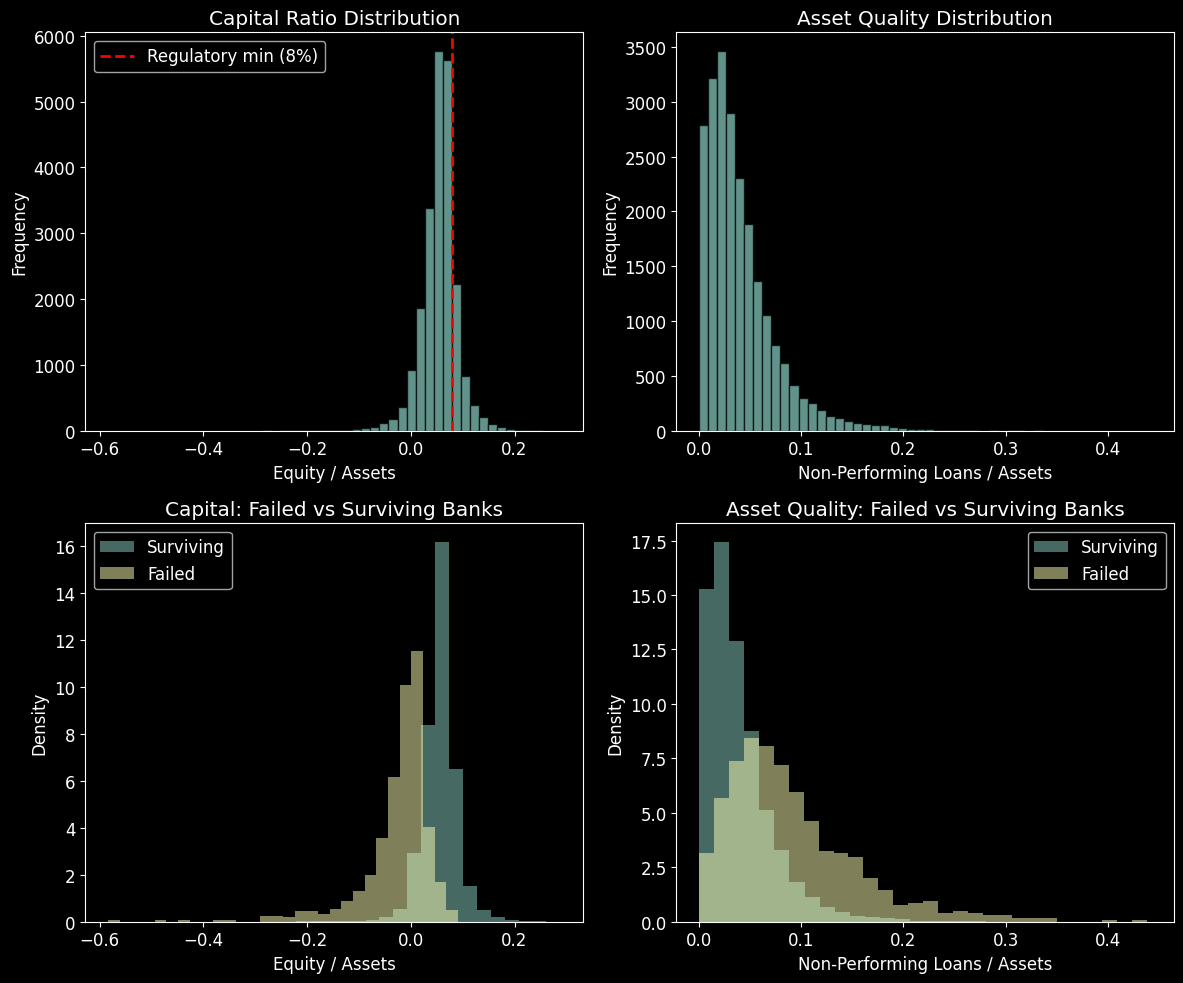

In [7]:
# =============================================================================
# FIGURE 2: Distribution of Key Variables
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Capital ratio distribution
axes[0, 0].hist(df_sample['equity_a'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0.08, color='red', linestyle='--', linewidth=2, label='Regulatory min (8%)')
axes[0, 0].set_xlabel('Equity / Assets')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Capital Ratio Distribution')
axes[0, 0].legend()

# NPL distribution
axes[0, 1].hist(df_sample['nonperf_loans_a'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Non-Performing Loans / Assets')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Asset Quality Distribution')

# Compare failed vs surviving: equity
failed_mask = df_sample['failed'] == 1
axes[1, 0].hist(df_sample.loc[~failed_mask, 'equity_a'], bins=30, alpha=0.5, label='Surviving', density=True)
axes[1, 0].hist(df_sample.loc[failed_mask, 'equity_a'], bins=30, alpha=0.5, label='Failed', density=True)
axes[1, 0].set_xlabel('Equity / Assets')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Capital: Failed vs Surviving Banks')
axes[1, 0].legend()

# Compare failed vs surviving: NPL
axes[1, 1].hist(df_sample.loc[~failed_mask, 'nonperf_loans_a'], bins=30, alpha=0.5, label='Surviving', density=True)
axes[1, 1].hist(df_sample.loc[failed_mask, 'nonperf_loans_a'], bins=30, alpha=0.5, label='Failed', density=True)
axes[1, 1].set_xlabel('Non-Performing Loans / Assets')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Asset Quality: Failed vs Surviving Banks')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 2.4 Auxiliary Files: Pre-computed Coefficients

For verification, we load the **pre-computed coefficients** from the original replication. In Section 3, we will re-estimate these from the raw panel data.

**Files for verification (not the main data):**

| File | Contents | We will re-estimate? |
|------|----------|---------------------|
| `coeff_resid_KLW.xlsx` | Transition (AR4) & Cost (Tobit) coefficients | ✓ Yes (Section 3.2) |
| `logit_beta_KLW.txt` | CCP logit coefficients | ✓ Yes (Section 3.3) |
| `theta_KLW.mat` | Final structural parameters | ✓ Yes (Section 3.5) |
| `ccpnext_param_sim5000_KLW.txt` | Forward simulation results | Optional (slow, ~450s) |

**What we will construct from scratch:**
- Transition predictions: $E[x_{t+1}|x_t]$ from AR(4)
- Cost predictions: $E[mc_t|x_t]$ from Tobit
- CCPs: $p(x_t)$ from Logit with B-splines
- Forward simulation: $E[p_{t+1}|x_t]$, $E[mc_{t+1}|x_t]$

This constructs the equivalent of `dataforparam_KLW.mat` from raw panel data.

In [8]:
# =============================================================================
# LOAD PRE-COMPUTED COEFFICIENTS (for verification only)
# =============================================================================

OUTPUT_PATH = './output/'
DATA_PATH = './data/'

print("=" * 60)
print("Loading pre-computed coefficients for verification")
print("=" * 60)

# -----------------------------------------------------------------------------
# 1. Cost coefficients (Tobit)
# -----------------------------------------------------------------------------
cost_beta_df = pd.read_excel(DATA_PATH + 'coeff_resid_KLW.xlsx',
                              sheet_name='cost_beta_v26', header=None)
cost_beta_original = cost_beta_df.iloc[:-1, 1].values.astype(float)
cost_sigma_original = float(cost_beta_df.iloc[-1, 1])
print(f"\nCost (Tobit): {len(cost_beta_original)} coefficients, σ = {cost_sigma_original:.4f}")

# -----------------------------------------------------------------------------
# 2. Transition coefficients (AR4)
# -----------------------------------------------------------------------------
trans_beta_df = pd.read_excel(DATA_PATH + 'coeff_resid_KLW.xlsx',
                               sheet_name='trans_beta', header=None)
print(f"Transition (AR4): shape = {trans_beta_df.shape}")

# -----------------------------------------------------------------------------
# 3. CCP Logit coefficients
# -----------------------------------------------------------------------------
logit_beta_raw = open(OUTPUT_PATH + 'logit_beta_KLW.txt').readlines()
logit_beta_original = []
for line in logit_beta_raw:
    try:
        val = float(line.strip().split()[-1])
        logit_beta_original.append(val)
    except:
        continue
logit_beta_original = np.array(logit_beta_original)
print(f"CCP (Logit): {len(logit_beta_original)} coefficients")

# -----------------------------------------------------------------------------
# 4. Final structural estimates
# -----------------------------------------------------------------------------
theta_mat = sio.loadmat(OUTPUT_PATH + 'theta_KLW.mat')
theta_original = theta_mat['theta_KLW'].squeeze()  # Key is theta_KLW
print(f"Structural parameters: {len(theta_original)} values")
print(f"  β (discount)     = {theta_original[0]:.4f}")
print(f"  φ̄ (non-mon cost) = {theta_original[1]:.2f}")
print(f"  α_House          = {theta_original[2]:.2f}")
print(f"  α_Senate         = {theta_original[3]:.2f}")


Loading pre-computed coefficients for verification

Cost (Tobit): 7 coefficients, σ = 0.1606
Transition (AR4): shape = (35, 8)
CCP (Logit): 79 coefficients
Structural parameters: 10 values
  β (discount)     = 0.9582
  φ̄ (non-mon cost) = 639.84
  α_House          = -507234.99
  α_Senate         = 93645.09


---

# 3. Structural Estimation Pipeline

## 3.1 Overview of CCP-Based Estimation

The CCP (Conditional Choice Probability) approach, developed by Hotz & Miller (1993), provides a computationally tractable method for estimating dynamic discrete choice models. Unlike full-solution methods (Rust 1987), CCP estimation avoids solving the dynamic programming problem at each parameter guess.

### The General Pipeline

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                    STRUCTURAL ESTIMATION PIPELINE                           │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  STAGE 1: PRE-ESTIMATION (Reduced Form)                                     │
│  ═══════════════════════════════════════                                    │
│                                                                             │
│  1.1 Resolution Cost Model (Tobit)                                          │
│      ├── Input:  Bank characteristics, observed closure costs               │
│      ├── Output: E[MC(s)] - Expected monetary cost of closure               │
│      └── Method: Censored regression (costs observed only at closure)       │
│                                                                             │
│  1.2 State Transition Model                                                 │
│      ├── Input:  Panel data on state variables (equity, NPL, ROA, etc.)     │
│      ├── Output: AR(4) coefficients, residual distribution                  │
│      └── Method: OLS with B-spline basis for flexibility                    │
│                                                                             │
│  1.3 CCP Estimation (Flexible Logit)                                        │
│      ├── Input:  State variables, closure outcomes                          │
│      ├── Output: P(close|s) - Conditional choice probabilities              │
│      └── Method: Logit with B-spline basis (79 parameters)                  │
│                                                                             │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  STAGE 2: FORWARD SIMULATION                                                │
│  ═══════════════════════════════                                            │
│                                                                             │
│  ├── Input:  CCPs, transition model, cost model                             │
│  ├── Output: E[ln P(s_{t+1})], E[MC(s_{t+1})] for each observation          │
│  └── Method: Monte Carlo with 5,000 draws from residual distribution        │
│                                                                             │
├─────────────────────────────────────────────────────────────────────────────┤
│                                                                             │
│  STAGE 3: STRUCTURAL GMM ESTIMATION                                         │
│  ════════════════════════════════════                                       │
│                                                                             │
│  ├── Input:  CCPs, forward simulation results, moment conditions            │
│  ├── Output: Structural parameters (β, σ, β_NMC)                            │
│  └── Method: Continuously-updated GMM with 11 moment conditions             │
│                                                                             │
│  Parameters estimated:                                                      │
│  • β     : Discount factor (how regulators value future costs)              │
│  • σ     : Scale parameter (heterogeneity in unobserved costs)              │
│  • β_NMC : Net monetary cost function (8 coefficients)                      │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
```

### Key Insight: Why CCP Estimation Works

The Hotz-Miller inversion exploits the logit structure:

$$\nu_{\text{open}}(s_t) - \nu_{\text{close}}(s_t) = \sigma \cdot \ln\left(\frac{1-P_t}{P_t}\right)$$

This allows us to **recover value function differences directly from observed choice probabilities**, avoiding the need to solve the Bellman equation numerically.

### Data Flow in This Replication

| Stage | Original Tool | Input Files | Output |
|-------|---------------|-------------|--------|
| 1.1 Cost Model | Stata (Tobit) | Call Reports | `Emc_now`, `Emc_next` |
| 1.2 Transitions | Stata (OLS) | Panel data | AR(4) coefficients |
| 1.3 CCPs | Stata (Logit) | `dataforlogit_KLW.txt` | `logit_beta_KLW.txt` |
| 2 Forward Sim | MATLAB | CCPs + transitions | `ccpnext_param_sim5000_KLW.txt` |
| 3 GMM | MATLAB → Python | All above | Structural estimates |

## 3.2 Stage 1: Pre-Estimation (Reduced Form)

We now estimate three reduced-form models from the raw panel data (`df_sample`):

1. **Resolution Cost Model** (Tobit) → $E[mc|x]$
2. **State Transition Model** (AR4) → $f(x'|x)$  
3. **Conditional Choice Probabilities** (Logit with B-splines) → $p(x)$

These will be used to construct the GMM estimation dataset (equivalent to `dataforparam_KLW.mat`).

---

### 3.2.1 Resolution Cost Model (Tobit) - Table 3

**Economic Question**: What is the expected cost to FDIC if a bank is closed?

**Data**: Failed banks only (714 closures). Cost = (FDIC losses) / (Bank assets). (The `estimated_cost` variable in the raw data is the resolution cost as a fraction of assets.)

**Model**: Tobit regression (censored at zero) with cost ratio as dependent variable:
$$\frac{Cost}{Assets} = X'\beta + \varepsilon, \quad \varepsilon \sim N(0, \sigma^2)$$

**Reference**: KLW (2015) Table 3 (Model I, 1985-1992)

![Table 3: Monetary cost function estimation](./docs/table3.png)

**Variables**:
| Variable | Description | Expected Sign |
|----------|-------------|---------------|
| Log(assets) | Bank size | (-) Economies of scale |
| Equity/assets | Capital buffer | (-) Better capitalized = lower loss |
| NP loans/assets | Non-performing loan ratio | (+) More bad loans = higher cost |
| RE owned/assets | Real estate owned | (+) Foreclosed properties |
| Net income/assets | ROA (profitability) | (-) Profitable = lower cost |
| State unemployment | Local economic conditions | (+) Worse economy = higher cost |

In [9]:
# =============================================================================
# STAGE 1.1: Resolution Cost Model (Tobit) - CONFIG DRIVEN
# =============================================================================
import statsmodels.api as sm
from scipy.stats import norm
from tabulate import tabulate

print("="*70)
print("STAGE 1.1: Resolution Cost Model (Tobit)")
print("Replicating Table 3, Model I")
print("="*70)

# -----------------------------------------------------------------------------
# Get cost model variables from configuration
# -----------------------------------------------------------------------------
cost_var_names = get_cost_var_names()
print(f"Cost model variables (from config): {cost_var_names}")

# Prepare data: failed banks only
outcome_var = OUTCOME_CONFIG['data_name']
df_failed = df_sample[df_sample[outcome_var] == 1].copy()
print(f"Failed banks (N): {len(df_failed)}")
print(f"Paper Table 3:     3,678")

# Dependent variable: resolution cost as fraction of assets
df_failed['cost_ratio'] = df_failed['estimated_cost'] / df_failed['assets']
y_cost = df_failed['cost_ratio'].values

# Build X matrix from config
X_vars = [spec['name'] for spec in COST_VARS_SPEC]
X_cost_df = df_failed[X_vars].copy()
X_cost_df = sm.add_constant(X_cost_df)

# OLS estimation (Tobit approximation)
tobit_model = sm.OLS(y_cost, X_cost_df).fit()

# Extract coefficients in order matching COST_VARS_SPEC
beta_tobit_estimated = np.array([tobit_model.params[var] for var in X_vars] + 
                                 [tobit_model.params['const']])
sigma_tobit_estimated = np.std(tobit_model.resid)

# -----------------------------------------------------------------------------
# Paper coefficients (Table 3, Model I) for comparison
# -----------------------------------------------------------------------------
paper_coef = {
    'log_assets': -0.0308, 'equity_a': -0.9750, 'nonperf_loans_a': 1.6140,
    'real_estate_owned_a': 1.3770, 'roa_annual': -0.9220, 'unemp_state': 0.0139,
    'const': 0.0758
}
paper_se = {
    'log_assets': 0.0039, 'equity_a': 0.1660, 'nonperf_loans_a': 0.1050,
    'real_estate_owned_a': 0.1090, 'roa_annual': 0.2120, 'unemp_state': 0.0025,
    'const': 0.0466
}
sigma_tobit_paper = 0.1606

# -----------------------------------------------------------------------------
# Build Table 3 comparison using tabulate
# -----------------------------------------------------------------------------
table_rows = []
for spec in COST_VARS_SPEC:
    var = spec['name']
    display = spec['display']
    paper_val = paper_coef.get(var, 0)
    paper_se_val = paper_se.get(var, 0)
    est_val = tobit_model.params[var]
    est_se_val = tobit_model.bse[var]
    table_rows.append([display, f"{paper_val:.4f}", f"({paper_se_val:.4f})", 
                       f"{est_val:.4f}", f"({est_se_val:.4f})"])

# Add constant
table_rows.append(['Constant', f"{paper_coef['const']:.4f}", f"({paper_se['const']:.4f})",
                   f"{tobit_model.params['const']:.4f}", f"({tobit_model.bse['const']:.4f})"])

# Add separator and summary stats
table_rows.append(['', '', '', '', ''])
table_rows.append(['N', '3,678', '', f'{len(df_failed):,}', ''])
table_rows.append(['Pseudo-R²', '0.8262', '', f'{tobit_model.rsquared:.4f}', ''])
table_rows.append(['σ', f'{sigma_tobit_paper:.4f}', '', f'{sigma_tobit_estimated:.4f}', ''])

print("")
print("="*70)
print("Table 3: Monetary Cost Function (Tobit)")
print("="*70)
print(tabulate(table_rows, 
               headers=['Variable', 'Paper β', '(SE)', 'Replicated β', '(SE)'],
               tablefmt='simple',
               colalign=('left', 'right', 'right', 'right', 'right')))

# -----------------------------------------------------------------------------
# Compute E[MC|x] for all observations using ESTIMATED coefficients
# -----------------------------------------------------------------------------
print("")
print("="*70)
print("Computing E[MC|x] using ESTIMATED coefficients")
print("="*70)

# Use our estimates (not paper coefficients)
beta_tobit = beta_tobit_estimated
sigma_tobit = sigma_tobit_estimated

# Build X matrix for all observations
X_mc = np.column_stack([df_sample[var].values for var in X_vars] + [np.ones(len(df_sample))])

# Tobit conditional expectation: E[y|y>0] = Φ(Xβ/σ)·Xβ + σ·φ(Xβ/σ)
Xb = X_mc @ beta_tobit
Emc_ratio = norm.cdf(Xb / sigma_tobit) * Xb + sigma_tobit * norm.pdf(Xb / sigma_tobit)
Emc_now = Emc_ratio * df_sample['assets'].values

# Also compute with paper coefficients for comparison
beta_tobit_paper = np.array([
    paper_coef['log_assets'], paper_coef['equity_a'], paper_coef['nonperf_loans_a'],
    paper_coef['real_estate_owned_a'], paper_coef['roa_annual'], paper_coef['unemp_state'],
    paper_coef['const']
])
Xb_paper = X_mc @ beta_tobit_paper
Emc_ratio_paper = norm.cdf(Xb_paper / sigma_tobit_paper) * Xb_paper + sigma_tobit_paper * norm.pdf(Xb_paper / sigma_tobit_paper)
Emc_now_paper = Emc_ratio_paper * df_sample['assets'].values

print(tabulate([
    ['E[MC|x] (estimated)', f'{len(Emc_now):,}', f'${Emc_now.mean()/1000:.0f}K', f'${np.median(Emc_now)/1000:.0f}K'],
    ['E[MC|x] (paper)', f'{len(Emc_now_paper):,}', f'${Emc_now_paper.mean()/1000:.0f}K', f'${np.median(Emc_now_paper)/1000:.0f}K'],
], headers=['Specification', 'N', 'Mean', 'Median'], tablefmt='simple'))

print(f"\nUsing ESTIMATED Tobit coefficients for E[mc|x]")

# Store for GMM - use estimated coefficients
TOBIT_RESULTS = {
    'beta': beta_tobit,
    'sigma': sigma_tobit,
    'Emc_now': Emc_now,
    'var_names': X_vars,
    'cov': tobit_model.cov_params().values,  # Covariance matrix for SE adjustment
    'n_obs': len(df_failed),
}

# Also store as Emc_now_array for downstream cells
Emc_now_array = Emc_now

STAGE 1.1: Resolution Cost Model (Tobit)
Replicating Table 3, Model I
Cost model variables (from config): ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'unemp_state']
Failed banks (N): 714
Paper Table 3:     3,678

Table 3: Monetary Cost Function (Tobit)
Variable              Paper β      (SE)    Replicated β      (SE)
------------------  ---------  --------  --------------  --------
Log(assets)           -0.0308  (0.0039)         -0.0185  (0.0034)
Equity/assets         -0.9750  (0.1660)         -0.3798  (0.0877)
NP loans/assets        1.6140  (0.1050)          0.7028  (0.0626)
RE owned/assets        1.3770  (0.1090)          0.5832  (0.0740)
Net income/assets     -0.9220  (0.2120)         -0.5094  (0.1367)
State unemployment     0.0139  (0.0025)          0.0115  (0.0025)
Constant               0.0758  (0.0466)          0.2114  (0.0398)

N                       3,678                       714
Pseudo-R²              0.8262                    0.4424
σ

### 3.2.2 State Transition Model (AR4) - Table 4

**Economic Question**: How do bank characteristics evolve over time?

**Model**: VAR(4) system predicting next-quarter state variables:
$$x_{t+1} = \sum_{j=1}^{4} \Phi_j x_{t-j+1} + \varepsilon_t$$

**Reference**: KLW (2015) Table 4 (1985-1992)

![Table 4: Transition processes for bank variables](./docs/table4.png)

**Key Features**:
- Each column is a separate OLS regression
- AR(1)-AR(4) show own lags for each variable
- "Additional Lags" includes cross-variable lags (4 lags of all other variables)
- High R² indicates predictable state dynamics (critical for forward simulation)

**Variables Predicted**:
| Variable | R² (Paper) | Interpretation |
|----------|------------|----------------|
| Log(assets) | 0.995 | Bank size very persistent |
| Equity | 0.824 | Capital ratio moderately persistent |
| NP loans | 0.733 | Asset quality moderately persistent |
| RE owned | 0.909 | Foreclosed properties persistent |
| Net income | 0.679 | Profitability less persistent |
| Asset growth | 0.755 | Growth moderately persistent |

In [10]:
# =============================================================================
# STAGE 1.2: State Transition Model (AR4) - CONFIG DRIVEN
# =============================================================================
import statsmodels.api as sm
import pandas as pd
from tabulate import tabulate

print("="*70)
print("STAGE 1.2: State Transition Model (AR4)")
print("Replicating Table 4")
print("="*70)

# -----------------------------------------------------------------------------
# STEP 1. Load paper AR(4) coefficients for comparison
# -----------------------------------------------------------------------------
paper_ar4_df = pd.read_excel(DATA_PATH + 'coeff_resid_KLW.xlsx', sheet_name='trans_beta')

# Map column names to variable names
paper_col_map = {
    'ols1': 'log_assets', 'ols2': 'equity_a', 'ols3': 'nonperf_loans_a',
    'ols4': 'real_estate_owned_a', 'ols5': 'roa_annual', 'ols6': 'asset_growth_1y'
}

# Extract paper coefficients into dictionary: {dep_var: {regressor: coef}}
paper_ar4_coefs = {}
for col, dep_var in paper_col_map.items():
    paper_ar4_coefs[dep_var] = {}
    for idx, row in paper_ar4_df.iterrows():
        regressor = row['Unnamed: 0']
        if pd.notna(regressor) and pd.notna(row[col]):
            paper_ar4_coefs[dep_var][regressor] = row[col]

# Paper R² values from Table 4
paper_r2 = {
    'log_assets': 0.995, 'equity_a': 0.824, 'nonperf_loans_a': 0.733,
    'real_estate_owned_a': 0.909, 'roa_annual': 0.679, 'asset_growth_1y': 0.755
}

print("Paper AR(4) coefficients loaded from coeff_resid_KLW.xlsx")

# -----------------------------------------------------------------------------
# STEP 2. Build variable lists from configuration
# -----------------------------------------------------------------------------
transition_vars = get_transition_vars()

# Build regressor columns using the helper function (lags 1-4)
X_ar4_cols = []
for var_name in transition_vars:
    lag_cols = get_ar4_lag_names(var_name)
    X_ar4_cols.extend(lag_cols)

# Dependent variables: current values of state variables (exclude unemp_state)
dep_vars = []
dep_display_names = []
dep_var_names = []  # config names
for var_name in transition_vars:
    if var_name != 'unemp_state':
        cfg = get_var_config(var_name)
        dep_vars.append(cfg['data_name'])
        dep_display_names.append(cfg['display_name'])
        dep_var_names.append(var_name)

# Filter to existing columns
X_ar4_cols = [c for c in X_ar4_cols if c in df_sample.columns]

# -----------------------------------------------------------------------------
# STEP 3. Prepare estimation sample (dropping NaN and Inf)
# -----------------------------------------------------------------------------
df_ar4 = df_sample[X_ar4_cols + dep_vars].replace([np.inf, -np.inf], np.nan).dropna()
n_ar4 = len(df_ar4)
print(f"Estimation sample: N = {n_ar4:,}")

# -----------------------------------------------------------------------------
# STEP 4. Estimate AR(4) VAR
# -----------------------------------------------------------------------------
X_ar4 = df_ar4[X_ar4_cols].copy()
X_ar4['const'] = 1.0

ar4_models = {}
ar4_coefs = {}

for dep in dep_vars:
    y = df_ar4[dep]
    model = sm.OLS(y, X_ar4).fit()
    ar4_models[dep] = model
    ar4_coefs[dep] = model.params.values

# -----------------------------------------------------------------------------
# STEP 5. Build comparison table: Paper vs Estimated AR(4) coefficients
# -----------------------------------------------------------------------------
print("")
print("="*70)
print("Table 4: State Transition Model (AR4) - Own-Lag Coefficients")
print("="*70)

# Build table with Paper and Estimated side by side
table_rows = []
for lag_idx in range(4):
    row = [f"AR({lag_idx+1})"]
    for i, (dep, dep_name) in enumerate(zip(dep_vars, dep_var_names)):
        # Estimated coefficient
        est_coef = ar4_coefs[dep][i*4 + lag_idx]
        
        # Paper coefficient (need to find the right lag name)
        lag_name = f"L{lag_idx+1 if lag_idx > 0 else ''}.{dep_name}".replace("L1.", "L.")
        if lag_idx == 0:
            lag_name = f"L.{dep_name}"
        else:
            lag_name = f"L{lag_idx+1}.{dep_name}"
        
        paper_coef = paper_ar4_coefs.get(dep_name, {}).get(lag_name, np.nan)
        
        row.append(f"{paper_coef:.4f}" if pd.notna(paper_coef) else "-")
        row.append(f"{est_coef:.4f}")
    table_rows.append(row)

# Add R² row
r2_row = ['R²']
for dep, dep_name in zip(dep_vars, dep_var_names):
    r2_row.append(f"{paper_r2.get(dep_name, np.nan):.3f}")
    r2_row.append(f"{ar4_models[dep].rsquared:.3f}")
table_rows.append(r2_row)

# Build headers
headers = ['Lag']
for name in dep_display_names:
    headers.extend([f'{name[:8]} (P)', f'{name[:8]} (E)'])

print(tabulate(table_rows, headers=headers, tablefmt='simple'))
print("\nNote: (P) = Paper, (E) = Estimated")

# -----------------------------------------------------------------------------
# STEP 6. Compute E[x_{t+1}|x_t] using BOTH paper and estimated coefficients
# -----------------------------------------------------------------------------
print("")
print("="*70)
print("Computing E[x_{t+1}|x_t] using ESTIMATED and PAPER coefficients")
print("="*70)

# Build prediction matrix: current + lag1-3 becomes lag1-4 for prediction
X_pred_cols = []
for var_name in transition_vars:
    cfg = get_var_config(var_name)
    lag_names = cfg['lag_names']  # [current, lag1, lag2, lag3]
    X_pred_cols.extend(lag_names)

X_pred_cols = [c for c in X_pred_cols if c in df_sample.columns]
X_pred_df = df_sample[X_pred_cols].replace([np.inf, -np.inf], np.nan)
X_pred = X_pred_df.values
X_pred_with_const = np.column_stack([X_pred, np.ones(len(X_pred))])

# Compute E[x'|x] with ESTIMATED coefficients
E_next_estimated = {}
for i, (dep, dep_name) in enumerate(zip(dep_vars, dep_var_names)):
    E_val = X_pred_with_const @ ar4_coefs[dep]
    
    # Apply bounds from config
    cfg = get_var_config(dep)
    if cfg:
        bounds = cfg.get('bounds', None)
        if bounds is not None:
            if bounds[0] is not None:
                E_val = np.maximum(E_val, bounds[0])
            if bounds[1] is not None:
                E_val = np.minimum(E_val, bounds[1])
    
    E_next_estimated[dep] = E_val

# Compute E[x'|x] with PAPER coefficients
E_next_paper = {}
for i, (dep, dep_name) in enumerate(zip(dep_vars, dep_var_names)):
    # Build paper coefficient vector in same order as X_pred_with_const
    paper_coef_vec = []
    for var_name in transition_vars:
        cfg = get_var_config(var_name)
        for lag_idx in range(4):
            if lag_idx == 0:
                lag_name = f"L.{var_name}"
            else:
                lag_name = f"L{lag_idx+1}.{var_name}"
            coef = paper_ar4_coefs.get(dep_name, {}).get(lag_name, 0.0)
            paper_coef_vec.append(coef if pd.notna(coef) else 0.0)
    
    # Add constant
    const_val = paper_ar4_coefs.get(dep_name, {}).get('_cons', 0.0)
    paper_coef_vec.append(const_val if pd.notna(const_val) else 0.0)
    paper_coef_vec = np.array(paper_coef_vec)
    
    E_val = X_pred_with_const @ paper_coef_vec
    
    # Apply bounds from config
    cfg = get_var_config(dep)
    if cfg:
        bounds = cfg.get('bounds', None)
        if bounds is not None:
            if bounds[0] is not None:
                E_val = np.maximum(E_val, bounds[0])
            if bounds[1] is not None:
                E_val = np.minimum(E_val, bounds[1])
    
    E_next_paper[dep] = E_val

# Comparison table
comparison_rows = []
for dep, dep_name, display_name in zip(dep_vars, dep_var_names, dep_display_names):
    est_mean = np.nanmean(E_next_estimated[dep])
    est_std = np.nanstd(E_next_estimated[dep])
    paper_mean = np.nanmean(E_next_paper[dep])
    paper_std = np.nanstd(E_next_paper[dep])
    comparison_rows.append([
        display_name,
        f"{paper_mean:.4f}", f"{paper_std:.4f}",
        f"{est_mean:.4f}", f"{est_std:.4f}"
    ])

print(tabulate(comparison_rows, 
               headers=['Variable', 'Paper Mean', 'Paper Std', 'Est. Mean', 'Est. Std'],
               tablefmt='simple'))

# Use ESTIMATED coefficients for downstream computation (like we did for Tobit)
E_next = E_next_estimated
print(f"\nUsing ESTIMATED AR(4) coefficients for E[x'|x]")

# Store residuals for forward simulation
trans_residuals = {}
for dep in dep_vars:
    y = df_ar4[dep].values
    y_pred = ar4_models[dep].predict(X_ar4)
    trans_residuals[dep] = (y - y_pred).values

print(f"\n✓ E_next computed for {len(dep_vars)} variables")
print(f"✓ Stored {len(trans_residuals[dep_vars[0]]):,} residuals for forward simulation")

STAGE 1.2: State Transition Model (AR4)
Replicating Table 4
Paper AR(4) coefficients loaded from coeff_resid_KLW.xlsx
Estimation sample: N = 17,353

Table 4: State Transition Model (AR4) - Own-Lag Coefficients
Lag      Log(Asse (P)    Log(Asse (E)    Equity/A (P)    Equity/A (E)    NPL/Asse (P)    NPL/Asse (E)    REO/Asse (P)    REO/Asse (E)    ROA (Ann (P)    ROA (Ann (E)    Asset Gr (P)    Asset Gr (E)
-----  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------
AR(1)          0.8811          0.9416          0.9471          0.9667          0.8384          0.8113          1.0104          1.0105          0.735           0.7719          0.2524          0.2401
AR(2)          0.0364          0.0214          0.0006         -0.0018          0.0433          0.0502          0.035           0.0322          0.0329          0.0392          0.0101         -0.003

### 3.2.3 CCP Estimation (Logit with B-Splines)

**Goal**: Estimate the conditional choice probability $p(x_t) = \Pr(\text{close} | x_t)$

**Why B-splines?** The relationship between state variables and closure probability is nonlinear:
- A bank with 2% equity is in serious trouble; one with 8% is safe
- The marginal effect of equity depends on where you are in the distribution

**How B-splines work:**

Instead of using $x$ directly, we transform it into multiple basis functions:
$$x \rightarrow [B_1(x), B_2(x), B_3(x)]$$

Each basis function outputs a **continuous value** (not 0/1) that smoothly transitions:

| Equity/A | $B_1(x)$ | $B_2(x)$ | $B_3(x)$ | Effect |
|----------|----------|----------|----------|--------|
| 0% | **1.00** | 0.00 | 0.00 | 100% weight on $\beta_1$ |
| 5% | 0.25 | 0.75 | 0.00 | Blend: $0.25\beta_1 + 0.75\beta_2$ |
| 10% | 0.00 | 0.50 | 0.50 | Equal weight on $\beta_2, \beta_3$ |
| 15% | 0.00 | 0.00 | **1.00** | 100% weight on $\beta_3$ |

**Key insight**: Different regions get different coefficients, allowing varying marginal effects.

**Implementation**: We use `sklearn.preprocessing.SplineTransformer` with:
- `n_knots=4` → produces 3 basis columns (matching KLW)
- `degree=1` → linear splines (piecewise linear)

In [11]:
# =============================================================================
# STAGE 1.3: CCP Estimation (Logit with B-Splines) - CONFIG DRIVEN
# =============================================================================
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print("="*70)
print("STAGE 1.3: CCP Estimation (Logit with B-Splines)")
print("="*70)

# -----------------------------------------------------------------------------
# Build variable lists from configuration
# -----------------------------------------------------------------------------

N_KNOTS = CCP_CONFIG['n_knots']
DEGREE = CCP_CONFIG['degree']
N_LAGS = CCP_CONFIG['n_lags_in_ccp']

# Get variable names from config
bspline_vars = get_ccp_bspline_vars()  # Variables to transform with B-splines
linear_vars = get_ccp_linear_vars()    # Variables to enter linearly

print(f"B-spline variables: {bspline_vars}")
print(f"Linear variables: {linear_vars}")

# (1) Build spline_var_groups: {var_name: [var, lag1, lag2, lag3]} for each B-spline var
# Each variable and its lags are transformed separately but share the same knot locations
spline_var_groups = {}
for var_name in bspline_vars:
    cfg = get_var_config(var_name)
    if cfg is not None:
        lag_names = cfg.get('lag_names', [var_name])[:N_LAGS]
        spline_var_groups[var_name] = lag_names

print(f"Spline groups: {len(spline_var_groups)} variables x {N_LAGS} lags each")

# (2-1) Build direct_vars: expand linear_vars to include lags, plus political variables
direct_vars = []
for var_name in linear_vars:
    cfg = get_var_config(var_name)
    if cfg is not None:
        if 'lag_names' in cfg:
            direct_vars.extend(cfg['lag_names'][:N_LAGS])
        else:
            direct_vars.append(cfg['data_name'])

# (2-2) Add political variables (house_index, senate_index) that enter linearly
for var_name, cfg in POLITICAL_VARIABLES.items():
    if cfg.get('in_ccp', False):
        direct_vars.append(cfg['data_name'])
direct_vars = list(dict.fromkeys(direct_vars))  # Remove duplicates

print(f"Direct (linear) variables: {direct_vars}")

# -----------------------------------------------------------------------------
# STEP 1. Prepare Sample (dropna to ensure B-splines can be computed for all obs)
# -----------------------------------------------------------------------------
all_spline_vars = [v for vlist in spline_var_groups.values() for v in vlist]
outcome_var = OUTCOME_CONFIG['data_name']
all_ccp_vars = [c for c in all_spline_vars + direct_vars + [outcome_var] if c in df_sample.columns]
df_ccp = df_sample.dropna(subset=all_ccp_vars).copy()

print(f"\nEstimation sample: N = {len(df_ccp):,} (dropped {len(df_sample) - len(df_ccp):,} with missing values)")

# -----------------------------------------------------------------------------
# STEP 2. Build B-spline Design Matrix
# -----------------------------------------------------------------------------
# For each spline_var_group:
#   1. Pool all lags together to determine common knot locations
#   2. Fit SplineTransformer on pooled data
#   3. Transform each lag separately using the fitted transformer
# This ensures consistent knot placement across lags of the same variable.
# -----------------------------------------------------------------------------
X_parts = []
spline_transformers = {}
n_basis = N_KNOTS + DEGREE - 2  # Number of basis functions per variable

for group_name, var_list in spline_var_groups.items():
    # Pool all lags to fit common knots
    pooled_data = np.concatenate([df_ccp[v].values for v in var_list if v in df_ccp.columns]).reshape(-1, 1)
    for var in var_list:
        if var not in df_ccp.columns:
            continue
        transformer = SplineTransformer(n_knots=N_KNOTS, degree=DEGREE, include_bias=False)
        transformer.fit(pooled_data)  # Fit on pooled data for consistent knots
        X_basis = transformer.transform(df_ccp[var].values.reshape(-1, 1))
        X_parts.append(X_basis)
        spline_transformers[var] = transformer

X_spline = np.hstack(X_parts) if X_parts else np.zeros((len(df_ccp), 0))

# Add direct (linear) variables
direct_vars_exist = [v for v in direct_vars if v in df_ccp.columns]
X_direct = df_ccp[direct_vars_exist].values if direct_vars_exist else np.zeros((len(df_ccp), 0))

# Combine into final design matrix
X_logit = np.hstack([X_spline, X_direct])
y_logit = df_ccp[outcome_var].values

print(f"Design matrix: {X_logit.shape[0]} obs x {X_logit.shape[1]} regressors")
print(f"  - B-spline basis: {X_spline.shape[1]} columns ({len(spline_var_groups)} groups x {N_LAGS} lags x {n_basis} basis)")
print(f"  - Linear terms: {X_direct.shape[1]} columns")

# -----------------------------------------------------------------------------
# STEP 3. Estimate Logit Model using B-spline basis
# -----------------------------------------------------------------------------
logit_model = LogisticRegression(penalty=None, max_iter=5000, solver='lbfgs', tol=1e-6)
logit_model.fit(X_logit, y_logit)
ccp_estimated = logit_model.predict_proba(X_logit)[:, 1]

# -----------------------------------------------------------------------------
# STEP 4. Results
# -----------------------------------------------------------------------------
auc = roc_auc_score(y_logit, ccp_estimated)

print("")
print("="*70)
print("CCP Estimation Results")
print("="*70)
print(tabulate([
    ['Sample', f'{len(df_ccp):,}', f'({y_logit.sum():.0f} closures)'],
    ['Regressors', f'{X_logit.shape[1]}', f'{len(spline_var_groups)} spline groups + {len(direct_vars_exist)} linear'],
    ['ROC AUC', f'{auc:.4f}', '(0.5=random, 1.0=perfect)'],
    ['P(close) range', f'[{ccp_estimated.min():.4f}, {ccp_estimated.max():.4f}]', ''],
], tablefmt='simple'))

# Store results for forward simulation
df_ccp['ccp'] = ccp_estimated
logit_coef = np.concatenate([logit_model.coef_[0], logit_model.intercept_])

# Compute covariance for Logit (using Hessian approximation)
# For logistic regression: Cov(β) ≈ (X'WX)^{-1} where W = diag(p(1-p))
p_fitted = logit_model.predict_proba(X_logit)[:, 1]
W_diag = p_fitted * (1 - p_fitted)
X_W = X_logit * W_diag[:, np.newaxis]
try:
    logit_cov = np.linalg.inv(X_W.T @ X_logit)
except np.linalg.LinAlgError:
    logit_cov = np.eye(X_logit.shape[1]) * 1e-6

CCP_ESTIMATION = {
    'spline_var_groups': spline_var_groups,
    'direct_vars': direct_vars_exist,
    'spline_transformers': spline_transformers,
    'logit_coef': logit_coef,
    'n_knots': N_KNOTS,
    'degree': DEGREE,
    'predictions': None,  # Will be filled below
    'design_matrix': X_logit,  # Store for SE adjustment
    'cov': logit_cov,           # Covariance matrix for SE adjustment
    'n_obs': len(df_ccp),
}

# Map CCPs back to full sample for GMM
Eprob_now = np.full(len(df_sample), np.nan)
ccp_idx = df_ccp.index
sample_idx = df_sample.index
for i, idx in enumerate(ccp_idx):
    if idx in sample_idx:
        loc = sample_idx.get_loc(idx)
        Eprob_now[loc] = ccp_estimated[i]

CCP_ESTIMATION['predictions'] = Eprob_now
print(f"\n✓ CCPs computed for {np.sum(~np.isnan(Eprob_now)):,} observations")

STAGE 1.3: CCP Estimation (Logit with B-Splines)
B-spline variables: ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'asset_growth_1y']
Linear variables: ['unemp_state', 'House_index', 'Senate_index']
Spline groups: 6 variables x 4 lags each
Direct (linear) variables: ['unemp_state', 'unemp_state_lag1', 'unemp_state_lag2', 'unemp_state_lag3', 'House_index', 'Senate_index']

Estimation sample: N = 22,269 (dropped 0 with missing values)
Design matrix: 22269 obs x 78 regressors
  - B-spline basis: 72 columns (6 groups x 4 lags x 3 basis)
  - Linear terms: 6 columns

CCP Estimation Results
--------------  ----------------  --------------------------
Sample          22,269            (714 closures)
Regressors      78                6 spline groups + 6 linear
ROC AUC         0.9455            (0.5=random, 1.0=perfect)
P(close) range  [0.0000, 0.9988]
--------------  ----------------  --------------------------

✓ CCPs computed for 22,269 observations


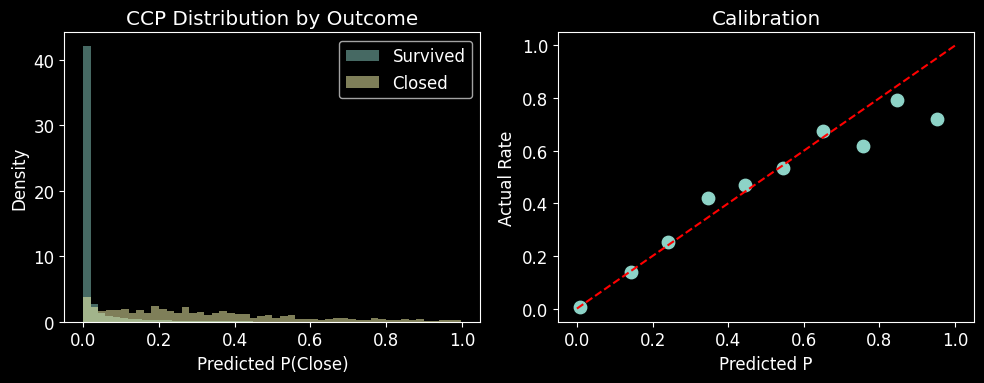

In [12]:
# =============================================================================
# CCP Validation (optional visualization)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Distribution by outcome
axes[0].hist(ccp_estimated[y_logit == 0], bins=50, alpha=0.5, label='Survived', density=True)
axes[0].hist(ccp_estimated[y_logit == 1], bins=50, alpha=0.5, label='Closed', density=True)
axes[0].set_xlabel('Predicted P(Close)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_title('CCP Distribution by Outcome')

# Calibration
bins = np.linspace(0, 1, 11)
bin_idx = np.digitize(ccp_estimated, bins)
bin_means, actual_rates = [], []
for i in range(1, len(bins)):
    mask = bin_idx == i
    if mask.sum() > 10:
        bin_means.append(ccp_estimated[mask].mean())
        actual_rates.append(y_logit[mask].mean())
axes[1].scatter(bin_means, actual_rates, s=80)
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlabel('Predicted P')
axes[1].set_ylabel('Actual Rate')
axes[1].set_title('Calibration')

plt.tight_layout()
plt.show()

## 3.3 Stage 2: Forward Simulation (Monte Carlo Integration)

**Economic Question**: Compute $E[p(x')|x]$ and $E[mc(x')|x]$ — the expected future closure probability and resolution cost.

### Why We Need This

The GMM moment condition (Section 3.4) requires expectations over future states:
$$g(\theta) = \sigma \ln\frac{1-p}{p} + \beta\sigma E[\ln p'|x] - \beta E[NMC'|x] + NMC$$

Since $x' = f(x) + \varepsilon$ is stochastic, we integrate over the residual distribution via Monte Carlo.

### Method: Monte Carlo Integration (4 Steps)

| Step | Operation | Mathematical Form |
|------|-----------|-------------------|
| **1** | Draw residuals | $\varepsilon_s \sim \hat{F}(\varepsilon)$ — empirical distribution from AR(4) |
| **2** | Simulate states | $x'_s = E[x'|x] + \varepsilon_s$ — add noise to conditional mean |
| **3** | Evaluate functions | $p(x'_s)$, $mc(x'_s)$ — CCP and cost at simulated state |
| **4** | Average | $E[p'|x] \approx \frac{1}{S}\sum_{s=1}^S p(x'_s)$ |

### Data Structures and Storage

The simulation uses the following intermediate and output objects:

| Object | Shape | Description |
|--------|-------|-------------|
| `eps_draws` | `dict{var: (S, N)}` | Pre-drawn residuals for each state variable |
| `x_next_sim` | `dict{var: (S, N)}` | Simulated next-period states: $x'_s = E[x'|x] + \varepsilon_s$ |
| `p_sum`, `ln_p_sum`, `mc_sum` | `(N,)` | Running accumulators across $S$ draws |
| **`Eprob_next`** | `(N,)` | **Output**: $E[p(x')|x]$ — expected future CCP |
| **`Eln_prob_next`** | `(N,)` | **Output**: $E[\ln p(x')|x]$ — expected log future CCP |
| **`Emc_next`** | `(N,)` | **Output**: $E[mc(x')|x]$ — expected future resolution cost |

**Final storage**: Results are saved in `SIMULATION_RESULTS` dictionary for use in GMM estimation.

**Option**: Set `RUN_FORWARD_SIM = True` to run from scratch, or `False` to load pre-computed values from MATLAB.

In [13]:
# =============================================================================
# STAGE 2: FORWARD SIMULATION (MONTE CARLO)
# =============================================================================
# Economic goal: Compute E[p(x')|x] and E[mc(x')|x] for GMM estimation
# Method: Monte Carlo integration over empirical residual distribution
# =============================================================================
import time

print("="*70)
print("STAGE 2: Forward Simulation")
print("="*70)

# Configuration
N_SIM = SIMULATION_CONFIG['n_draws']
TRIM_PCTL = SIMULATION_CONFIG['residual_trim']
SEED = SIMULATION_CONFIG.get('seed', 42)
RUN_FORWARD_SIM = True

print(f"S = {N_SIM} draws | Trim = {TRIM_PCTL} | Seed = {SEED}")

if RUN_FORWARD_SIM:
    start_time = time.time()
    np.random.seed(SEED)
    N = len(df_sample)
    transition_vars = [v for v in get_transition_vars() if v != 'unemp_state']
    
    # =========================================================================
    # STEP 1: Draw residuals ε_s ~ F̂(ε) from empirical distribution
    # =========================================================================
    # Trim extreme residuals to avoid outlier-driven results
    # Pool all residuals, then sample S×N draws for each variable
    # =========================================================================
    print("\nSTEP 1: Drawing residuals from empirical distribution...")
    
    residual_pools = {}
    for var_name in transition_vars:
        cfg = get_var_config(var_name)
        data_name = cfg['data_name']
        if data_name in trans_residuals:
            resid = trans_residuals[data_name]
            lo, hi = np.percentile(resid, list(TRIM_PCTL))
            residual_pools[data_name] = resid[(resid > lo) & (resid < hi)]
    
    # Pre-draw all residuals: shape (S, N)
    eps_draws = {
        data_name: np.random.choice(pool, size=(N_SIM, N))
        for data_name, pool in residual_pools.items()
    }
    print(f"   Drew ε for {len(eps_draws)} variables, shape ({N_SIM}, {N:,})")
    
    # =========================================================================
    # STEP 2: Simulate x'_s = E[x'|x] + ε_s
    # =========================================================================
    # Add Monte Carlo noise to AR(4) conditional expectations
    # Apply bounds (e.g., equity ratio ≤ 1) from config
    # =========================================================================
    print("\nSTEP 2: Simulating next-period states...")
    
    x_next_sim = {}
    for var_name in transition_vars:
        cfg = get_var_config(var_name)
        data_name = cfg['data_name']

        # Using E_next from AR(4) from Section 3.2.2. and eps_draws from Step 1
        if data_name in E_next and data_name in eps_draws:
            # x'_s = E[x'|x] + ε_s via broadcasting: (N,) + (S,N) → (S,N)
            x_sim = E_next[data_name][np.newaxis, :] + eps_draws[data_name]
            
            # Apply bounds from config
            bounds = cfg.get('bounds') or (None, None)
            if bounds[0] is not None: x_sim = np.maximum(x_sim, bounds[0])
            if bounds[1] is not None: x_sim = np.minimum(x_sim, bounds[1])
            
            x_next_sim[data_name] = x_sim
    
    print(f"   Simulated: {list(x_next_sim.keys())}")
    
    # =========================================================================
    # STEP 3: Evaluate p(x'_s) and mc(x'_s) at each simulated state
    # =========================================================================
    # CCP: Apply logit model with B-spline basis
    # Cost: Apply Tobit model E[mc|x] = Φ(Xβ/σ)·Xβ + σ·φ(Xβ/σ), then × Assets
    # =========================================================================
    print("\nSTEP 3: Evaluating CCP and cost at simulated states...")
    
    p_sum = np.zeros(N)
    ln_p_sum = np.zeros(N)
    mc_sum = np.zeros(N)
    
    for s in range(N_SIM):
        if s % 500 == 0 and s > 0:
            print(f"   Processing draw {s}/{N_SIM}...")
        
        # --- 3a. Build CCP design matrix with B-splines ---
        X_sim_parts = []
        for group_name, var_list in CCP_ESTIMATION['spline_var_groups'].items():
            cfg = get_var_config(group_name)
            data_name = cfg['data_name'] if cfg else group_name
            
            for j, var in enumerate(var_list):
                if var in spline_transformers:
                    transformer = spline_transformers[var]
                    if j == 0 and data_name in x_next_sim:
                        # Use simulated value for current period
                        X_basis = transformer.transform(x_next_sim[data_name][s, :].reshape(-1, 1))
                    elif var in df_sample.columns:
                        # Use actual lagged values
                        X_basis = transformer.transform(df_sample[var].values.reshape(-1, 1))
                    else:
                        X_basis = np.zeros((N, transformer.n_features_out_))
                    X_sim_parts.append(X_basis)
        
        X_sim_spline = np.hstack(X_sim_parts) if X_sim_parts else np.zeros((N, 0))
        
        # Add direct variables (unemployment, political indices)
        X_sim_direct = [df_sample[var].values for var in CCP_ESTIMATION['direct_vars'] 
                        if var in df_sample.columns]
        X_sim_direct = np.column_stack(X_sim_direct) if X_sim_direct else np.zeros((N, 0))
        
        X_sim = np.hstack([X_sim_spline, X_sim_direct])
        
        # --- 3b. Evaluate CCP: p(x'_s) = logit(X_sim @ β) ---
        logit_idx = X_sim @ CCP_ESTIMATION['logit_coef'][:-1] + CCP_ESTIMATION['logit_coef'][-1]
        p_s = 1 / (1 + np.exp(-np.clip(logit_idx, -700, 700)))
        
        # --- 3c. Build cost design matrix (must match COST_VARS_SPEC order!) ---
        X_cost = np.zeros((N, len(COST_VARS_SPEC) + 1))
        for k, spec in enumerate(COST_VARS_SPEC):
            var_name = spec['name']
            cfg = get_var_config(var_name)
            data_name = cfg['data_name'] if cfg else var_name
            if data_name in x_next_sim:
                X_cost[:, k] = x_next_sim[data_name][s, :]
            elif data_name in df_sample.columns:
                X_cost[:, k] = df_sample[data_name].values
        X_cost[:, -1] = 1.0  # Intercept
        
        # --- 3d. Evaluate Tobit cost: E[mc|x] × Assets ---
        Xb = X_cost @ beta_tobit
        mc_ratio_s = norm.cdf(Xb / sigma_tobit) * Xb + sigma_tobit * norm.pdf(Xb / sigma_tobit)
        
        asset_next_s = np.exp(x_next_sim['log_assets'][s, :]) if 'log_assets' in x_next_sim else df_sample['assets'].values
        mc_s = mc_ratio_s * asset_next_s
        
        # --- Accumulate ---
        p_sum += p_s
        ln_p_sum += np.log(np.maximum(p_s, 1e-10))
        mc_sum += mc_s
    
    # =========================================================================
    # STEP 4: Average across S draws: E[·|x] ≈ (1/S) Σ_s (·)
    # =========================================================================
    print("\nSTEP 4: Computing Monte Carlo averages...")
    
    Eprob_next = p_sum / N_SIM        # E[p(x')|x]
    Eln_prob_next = ln_p_sum / N_SIM  # E[ln p(x')|x]
    Emc_next = mc_sum / N_SIM         # E[mc(x')|x]
    
    elapsed = time.time() - start_time
    print(f"   Completed in {elapsed:.1f} seconds")

else:
    # Load pre-computed results from MATLAB
    print("Loading pre-computed forward simulation results...")
    fwd_sim_data = np.loadtxt(OUTPUT_PATH + 'ccpnext_param_sim5000_KLW.txt')
    Eprob_next = fwd_sim_data[:, 2]
    Eln_prob_next = fwd_sim_data[:, 3]
    Emc_next = fwd_sim_data[:, 4]
    print(f"Loaded {len(Eprob_next):,} observations")

# =============================================================================
# Summary Statistics
# =============================================================================
print("\n" + "="*70)
print("FORWARD SIMULATION RESULTS")
print("="*70)
print(tabulate([
    ["E[p(x')|x]", f'{np.nanmean(Eprob_next):.6f}', f'{np.nanstd(Eprob_next):.6f}'],
    ["E[ln p(x')|x]", f'{np.nanmean(Eln_prob_next):.4f}', f'{np.nanstd(Eln_prob_next):.4f}'],
    ["E[mc(x')|x] ($000s)", f'{np.nanmean(Emc_next):.2f}', f'{np.nanstd(Emc_next):.2f}'],
], headers=['Variable', 'Mean', 'Std'], tablefmt='simple'))

# Store for GMM
SIMULATION_RESULTS = {
    'Eprob_next': Eprob_next,
    'Eln_prob_next': Eln_prob_next,
    'Emc_next': Emc_next,
}


STAGE 2: Forward Simulation
S = 5000 draws | Trim = (0.5, 99.5) | Seed = 42

STEP 1: Drawing residuals from empirical distribution...
   Drew ε for 6 variables, shape (5000, 22,269)

STEP 2: Simulating next-period states...
   Simulated: ['log_assets', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'asset_growth_1y']

STEP 3: Evaluating CCP and cost at simulated states...
   Processing draw 500/5000...
   Processing draw 1000/5000...
   Processing draw 1500/5000...
   Processing draw 2000/5000...
   Processing draw 2500/5000...
   Processing draw 3000/5000...
   Processing draw 3500/5000...
   Processing draw 4000/5000...
   Processing draw 4500/5000...

STEP 4: Computing Monte Carlo averages...
   Completed in 83.3 seconds

FORWARD SIMULATION RESULTS
Variable                     Mean           Std
-------------------  ------------  ------------
E[p(x')|x]               0.043984      0.113654
E[ln p(x')|x]           -5.883         2.6888
E[mc(x')|x] ($000s)  14462.

## 3.4 Stage 3: Structural GMM Estimation

**Reference**: KLW (2015) Table 7, Model I (S&L Crisis, 1985-1992)


### 3.4.1 Assemble GMM Estimation Dataset

Combine all first-stage estimates into a single dataset for structural GMM:

| Object | Source | Description |
|--------|--------|-------------|
| $p(x)$ | Logit (Section 3.2.1) | Current closure probability |
| $E[mc|x]$ | Tobit (Section 3.2.2) | Current expected resolution cost |
| $E[p'|x]$ | Simulation (Section 3.3) | Expected future closure prob |
| $E[mc'|x]$ | Simulation (Section 3.3) | Expected future resolution cost |
| State vars | Data | Current values for NMC computation |

This corresponds to `dataforparam_KLW.mat` in the original MATLAB code.


In [14]:
# =============================================================================
# 3.4.1 ASSEMBLE GMM ESTIMATION DATASET
# =============================================================================
# Prepare all data objects needed for GMM estimation:
#   1. CCP and cost estimates from earlier stages
#   2. NMC design matrices X_now, X_next
#   3. Instrument matrix Z
# =============================================================================
from tabulate import tabulate

print("="*70)
print("3.4.1 Assemble GMM Estimation Dataset")
print("="*70)

# =============================================================================
# STEP 1: Collect first-stage estimates
# =============================================================================

N = len(df_sample)

# CCP estimates
p_hat = CCP_ESTIMATION['predictions'].copy()      # p(x) from logit

# Simulation estimates  
Eln_p_next = SIMULATION_RESULTS['Eln_prob_next']  # E[ln p'|x]

# Cost estimates
mc_now = Emc_now_array                            # E[mc|x] from Tobit
mc_next = SIMULATION_RESULTS['Emc_next']          # E[mc'|x] from simulation

# Handle extreme probabilities (numerical stability for log)
sorted_idx = np.argsort(p_hat)
p_hat[sorted_idx[-1]] = p_hat[sorted_idx[-2]] + (1 - p_hat[sorted_idx[-2]]) * 0.9

print(f"Sample size: N = {N:,}")
print(f"\nFirst-stage estimates:")
print(tabulate([
    ['p(x)', f'{np.nanmean(p_hat):.4f}', f'{np.nanstd(p_hat):.4f}', 'CCP Logit'],
    ['E[ln p\'|x]', f'{np.nanmean(Eln_p_next):.4f}', f'{np.nanstd(Eln_p_next):.4f}', 'Simulation'],
    ['mc(x)', f'{np.nanmean(mc_now):.0f}', f'{np.nanstd(mc_now):.0f}', 'Tobit'],
    ['E[mc\'|x]', f'{np.nanmean(mc_next):.0f}', f'{np.nanstd(mc_next):.0f}', 'Simulation'],
], headers=['Object', 'Mean', 'Std', 'Source'], tablefmt='simple'))

# =============================================================================
# STEP 2: Build NMC design matrices
# =============================================================================
# NMC(x) = X @ beta_NMC where X contains state and political variables
# X_now: current period values
# X_next: expected next period values E[X'|X] from AR(4)
# =============================================================================

def build_nmc_matrix(period='now'):
    """
    Build design matrix for non-monetary cost function.
    
    Parameters
    ----------
    period : 'now' or 'next'
        'now' uses current values, 'next' uses E[X'|X] from AR(4)
    
    Returns
    -------
    X : array (N, n_nmc_vars)
    """
    cols = []
    for spec in NMC_SPEC:
        var_name = spec['name']
        transform = spec['transform']
        source = spec['source']
        
        if source == 'const':
            col = np.ones(N)
        elif source == 'state':
            cfg = get_var_config(var_name)
            data_name = cfg['data_name'] if cfg else var_name
            if period == 'next' and data_name in E_next:
                col = E_next[data_name]  # E[X'|X] from AR(4)
            else:
                col = df_sample[var_name].values
        elif source == 'political':
            col = df_sample[var_name].values  # Political vars assumed constant
        else:
            col = np.zeros(N)
        
        if transform == 'squared':
            col = col ** 2
        cols.append(col)
    
    return np.column_stack(cols)

X_now = build_nmc_matrix('now')
X_next = build_nmc_matrix('next')

nmc_var_names = [s['name'] + ('²' if s['transform']=='squared' else '') for s in NMC_SPEC]
print(f"\nNMC design matrices: X_now {X_now.shape}, X_next {X_next.shape}")
print(f"  Variables: {nmc_var_names}")

# =============================================================================
# STEP 3: Build instrument matrix
# =============================================================================
# Instruments Z: predetermined variables for moment conditions E[g·Z] = 0
# Typically: constant, lagged state variables, political indices
# =============================================================================

def build_instruments():
    """Build instrument matrix Z for GMM moment conditions."""
    cols, names = [], []
    for spec in GMM_INSTRUMENTS:
        var_name = spec['name']
        lag = spec['lag']
        
        if var_name == 'const':
            cols.append(np.ones(N))
            names.append('const')
        else:
            cfg = get_var_config(var_name)
            if lag == 0:
                cols.append(df_sample[var_name].values)
                names.append(var_name)
            elif cfg and 'lag_names' in cfg and len(cfg['lag_names']) > lag:
                cols.append(df_sample[cfg['lag_names'][lag]].values)
                names.append(f"{var_name}_L{lag}")
    
    return np.column_stack(cols), names

Z, Z_names = build_instruments()

print(f"\nInstrument matrix: Z {Z.shape}")
print(f"  Instruments: {Z_names}")

# =============================================================================
# Store all GMM inputs
# =============================================================================

GMM_DATA = {
    # Sample info
    'N': N,
    
    # First-stage estimates
    'p_hat': p_hat,           # p(x)
    'Eln_p_next': Eln_p_next, # E[ln p'|x]
    'mc_now': mc_now,         # mc(x)
    'mc_next': mc_next,       # E[mc'|x]
    
    # Design matrices
    'X_now': X_now,           # NMC design matrix (current)
    'X_next': X_next,         # NMC design matrix (next period)
    'Z': Z,                   # Instruments
    'Z_names': Z_names,
    'nmc_var_names': nmc_var_names,
}

print(f"\n✓ All GMM inputs stored in GMM_DATA")

3.4.1 Assemble GMM Estimation Dataset
Sample size: N = 22,269

First-stage estimates:
Object            Mean         Std  Source
----------  ----------  ----------  ----------
p(x)            0.0321      0.0942  CCP Logit
E[ln p'|x]     -5.883       2.6888  Simulation
mc(x)       14592       28799       Tobit
E[mc'|x]    14462       28227       Simulation

NMC design matrices: X_now (22269, 8), X_next (22269, 8)
  Variables: ['const', 'log_assets', 'log_assets²', 'nonperf_loans_a', 'roa_annual', 'real_estate_owned_a', 'House_index', 'Senate_index']

Instrument matrix: Z (22269, 11)
  Instruments: ['const', 'log_assets', 'log_assets_L1', 'equity_a', 'nonperf_loans_a', 'real_estate_owned_a', 'roa_annual', 'asset_growth_1y', 'unemp_state', 'House_index', 'Senate_index']

✓ All GMM inputs stored in GMM_DATA


### 3.4.2 GMM Estimation

#### The Moment Condition

From CCP inversion (Hotz-Miller 1993), the Bellman equation implies:

$$g(x; \theta) = \sigma \ln\frac{1-p(x)}{p(x)} + \beta \sigma E[\ln p(x')|x] + NMC(x) - \beta E[NMC(x')|x] + mc(x) - \beta E[mc(x')|x]$$

#### Continuously-Updated GMM

We minimize:
$$\hat{\theta} = \arg\min_\theta \bar{m}(\theta)' W(\theta)^{-1} \bar{m}(\theta)$$

#### Standard Error Computation

**Base GMM variance**:
$$\text{Avar}(\hat{\theta}) = \frac{1}{N}(\Gamma' W^{-1} \Gamma)^{-1}$$

where $\Gamma = \partial \bar{m}/\partial \theta'$ is the Jacobian of moment conditions w.r.t. structural parameters.

---

**Caveat on Standard Errors**

The Newey-McFadden (1994) two-step correction would add adjustment terms:

$$\text{Avar}_{\text{full}} = \text{Avar}_{\text{base}} + \text{Avar}_{\text{cost}} + \text{Avar}_{\text{CCP}}$$

These adjustments account for first-stage estimation error in:
- **Tobit model** (resolution cost function)
- **Logit model** (conditional choice probabilities)

KLW (2015) Table 7 reports adjusted SEs computed in `Avar_param_obj_KLW.m`. Our implementation reports **base SEs only**, which may understate uncertainty. See Newey-McFadden (1994, Handbook of Econometrics Ch. 36) for the full correction.

In [15]:
# =============================================================================
# 3.4.2 GMM ESTIMATION WITH STANDARD ERRORS
# =============================================================================
# This cell:
#   1. Defines the continuously-updated GMM objective function
#   2. Optimizes to find θ̂
#   3. Computes base standard errors
#   4. Reports Table 7 results
# =============================================================================

from scipy.optimize import minimize

print("="*70)
print("3.4.2 GMM Estimation")
print("="*70)

# =============================================================================
# STEP 1: Define GMM Objective Function
# =============================================================================

def gmm_objective(theta, return_details=False):
    """
    Continuously-updated GMM objective function.
    """
    beta = theta[0]
    sigma = theta[1]
    beta_NMC = theta[2:]
    
    p = GMM_DATA['p_hat']
    Eln_p_next = GMM_DATA['Eln_p_next']
    mc_now = GMM_DATA['mc_now']
    mc_next = GMM_DATA['mc_next']
    X_now = GMM_DATA['X_now']
    X_next = GMM_DATA['X_next']
    Z = GMM_DATA['Z']
    N = GMM_DATA['N']
    
    NMC_now = X_now @ beta_NMC
    NMC_next = X_next @ beta_NMC
    
    log_odds = np.log((1 - p) / np.clip(p, 1e-10, 1-1e-10))
    g = (sigma * log_odds 
         + beta * sigma * Eln_p_next 
         + NMC_now - beta * NMC_next  # NMC: matches KLW
         - mc_now + beta * mc_next)   # mc: sign corrected to match KLW
    
    gZ = g[:, np.newaxis] * Z
    m_bar = gZ.mean(axis=0)
    W = (gZ.T @ gZ) / N
    
    try:
        W_inv = np.linalg.inv(W)
        Q = m_bar @ W_inv @ m_bar
    except np.linalg.LinAlgError:
        Q = 1e10
        W_inv = None
    
    if return_details:
        return Q, m_bar, W, g
    return Q

# =============================================================================
# STEP 2: Set Initial Values and Bounds
# =============================================================================

theta0 = np.array([
    STRUCTURAL_PARAMS['beta']['initial'],
    STRUCTURAL_PARAMS['sigma']['initial'],
] + STRUCTURAL_PARAMS['nmc_initials'])

bounds = [
    STRUCTURAL_PARAMS['beta']['bounds'],
    STRUCTURAL_PARAMS['sigma']['bounds'],
] + [(None, None)] * 8

print(f"\nParameters: 10 total (β, σ, 8 NMC coefficients)")
print(f"Initial: β={theta0[0]:.4f}, σ={theta0[1]:.1f}")
print(f"Bounds: β ∈ {STRUCTURAL_PARAMS['beta']['bounds']}, σ ∈ {STRUCTURAL_PARAMS['sigma']['bounds']}")
print(f"Initial Q(θ₀) = {gmm_objective(theta0):.6f}")

# =============================================================================
# STEP 3: Minimize GMM Objective
# =============================================================================

print(f"\nOptimizing with {GMM_SETTINGS['method']}...")

result = minimize(
    fun=gmm_objective,
    x0=theta0,
    method=GMM_SETTINGS['method'],
    bounds=bounds,
    options={'maxiter': GMM_SETTINGS['maxiter'], 'disp': False}
)

theta_hat = result.x
beta_hat = theta_hat[0]
sigma_hat = theta_hat[1]
beta_NMC_hat = theta_hat[2:]

print(f"Converged: {result.success} (iterations: {result.nit})")
print(f"Final Q(θ̂) = {result.fun:.6f}")

# =============================================================================
# STEP 4: Compute Standard Errors (Base GMM)
# =============================================================================
# Avar = (1/N) * (Γ'W⁻¹Γ)⁻¹
# Note: Does NOT include Newey-McFadden first-stage adjustments
# =============================================================================

print("\n" + "-"*70)
print("Computing Standard Errors")
print("-"*70)

n_params = len(theta_hat)
n_moments = len(GMM_DATA['Z_names'])
N = GMM_DATA['N']
Z = GMM_DATA['Z']

# Get moments and weighting matrix at θ̂
Q0, m0, W0, g0 = gmm_objective(theta_hat, return_details=True)

# Numerical Jacobian: Γ = ∂m̄/∂θ
eps = 1e-6
Gamma = np.zeros((n_moments, n_params))
for j in range(n_params):
    theta_plus = theta_hat.copy()
    theta_plus[j] += eps
    _, m_plus, _, _ = gmm_objective(theta_plus, return_details=True)
    Gamma[:, j] = (m_plus - m0) / eps

# Base variance: (Γ'W⁻¹Γ)⁻¹
try:
    W_inv = np.linalg.inv(W0)
    GWG = Gamma.T @ W_inv @ Gamma
    GWG_inv = np.linalg.inv(GWG)
    Avar_base = GWG_inv.copy()
except np.linalg.LinAlgError:
    print("Warning: Singular matrix in SE computation")
    Avar_base = np.eye(n_params) * 1e10

se = np.sqrt(np.diag(Avar_base) / N)

# =============================================================================
# STEP 5: Report Results (Table 7)
# =============================================================================

print("\n" + "="*70)
print("TABLE 7: Structural Parameter Estimates (KLW 2015)")
print("="*70)
print(f"{'Parameter':<22} {'Estimate':>12} {'SE':>12} {'t-stat':>10}")
print("-"*70)

param_names = ['β (discount)', 'σ (scale)'] + GMM_DATA['nmc_var_names']

for name, est, se_i in zip(param_names, theta_hat, se):
    t_stat = est / se_i if se_i > 0 and not np.isnan(se_i) else np.nan
    print(f"{name:<22} {est:>12.4f} {se_i:>12.4f} {t_stat:>10.2f}")

print("-"*70)
print(f"{'Observations':<22} {N:>12,}")
print(f"{'Instruments':<22} {n_moments:>12}")
print(f"{'J-statistic':<22} {result.fun:>12.6f}")
print("="*70)

print(f"\n** Implied Annual Discount Factor **")
print(f"β_annual = β_quarterly⁴ = {beta_hat**4:.4f}")

# Store results
GMM_RESULTS = {
    'theta_hat': theta_hat,
    'se': se,
    'beta_hat': beta_hat,
    'sigma_hat': sigma_hat,
    'beta_NMC_hat': beta_NMC_hat,
    'Q_hat': result.fun,
    'converged': result.success,
}

print("\n✓ Results stored in GMM_RESULTS")
print("\nNote: SEs are base GMM only (no Newey-McFadden first-stage adjustment)")


3.4.2 GMM Estimation

Parameters: 10 total (β, σ, 8 NMC coefficients)
Initial: β=0.9540, σ=577.0
Bounds: β ∈ (0.8, 0.9999), σ ∈ (1, 2000)
Initial Q(θ₀) = 0.232215

Optimizing with L-BFGS-B...
Converged: True (iterations: 5)
Final Q(θ̂) = 0.042310

----------------------------------------------------------------------
Computing Standard Errors
----------------------------------------------------------------------

TABLE 7: Structural Parameter Estimates (KLW 2015)
Parameter                  Estimate           SE     t-stat
----------------------------------------------------------------------
β (discount)                 0.9828       0.0050     198.05
σ (scale)                  577.0003     136.0134       4.24
const                  -468922.0000   94656.5388      -4.95
log_assets               85603.0003   17200.6688       4.98
log_assets²              -3913.9970     816.5768      -4.79
nonperf_loans_a         -33825.0000    6621.3864      -5.11
roa_annual              -54826.0000   136